

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.


# Imports

In [ ]:
from functools import partial
import copy
import time
import os

import flax
import h5py
import jax
import jax.numpy as jnp
import jax.experimental
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.distance import pdist, squareform
import scipy.linalg
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
jax.devices()

[PjRtTpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 PjRtTpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 PjRtTpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 PjRtTpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 PjRtTpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 PjRtTpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 PjRtTpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 PjRtTpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

# Code

## Tasks

### Box tasks

In [ ]:
seq_height_min, seq_height_max = 1.0, 25.0
seq_width_min, seq_width_max =  3.0, 20.0
seq_length = 100 # 100


relu = lambda x: jnp.where(x > 0.0, x, 0.0)


def positions_to_sequences(key, tr = None, bx = None, noise_level = 0.3):
  st = jnp.arange(seq_length).astype(np.float)
  st = st[None, :, None]
  tr = tr[:, None, :, :]
  bx = bx[:, None, :, :]

  y_key, _ = jax.random.split(key, 2)

  xtr = relu(tr[..., 1] - relu(jnp.abs(st - tr[..., 0]) - 0.5) * 2 * tr[..., 1] / tr[..., 2])
  xbx = jnp.sign(relu(bx[..., 1] - jnp.abs((st - bx[..., 0]) * 2 * bx[..., 1] / bx[..., 2]))) * bx[..., 1]
  x_bt4 = jnp.concatenate((xtr, xbx), 2)

  x_sign_bt4 = jnp.sign(x_bt4)
  u_bt4 = flax.nn.max_pool(x_sign_bt4, window_shape=(2,), strides=(1,), padding='VALID')
  u_b4t = jnp.transpose(u_bt4, (0, 2, 1))
  collisions = (u_b4t.sum(axis=1) > 1).max(axis=1)
   
  y_bt = x_bt4.max(axis=2)

  return y_bt + jax.random.uniform(y_key, y_bt.shape) * noise_level - noise_level / 2, collisions


def generate_sequences_inner(nb, noise_level, key):

  key, top_key = jax.random.split(key, 2)

  trkey, bxkey, pskey1, pskey2 = jax.random.split(top_key, 4)
  trkeys = jax.random.split(trkey, 3)
  bxkeys = jax.random.split(bxkey, 3)

  # Location, height, width
  tr1 = jax.random.uniform(trkeys[0], (nb, 2, 1), minval=seq_width_max/2, maxval=seq_length - seq_width_max/2)
  tr2 = jax.random.uniform(trkeys[1], (nb, 2, 1), minval=seq_height_min, maxval=seq_height_max)
  tr3 = jax.random.uniform(trkeys[2], (nb, 2, 1), minval=seq_width_min, maxval=seq_width_max)
  tr = jnp.concatenate((tr1, tr2, tr3), axis=2)

  bx1 = jax.random.uniform(bxkeys[0], (nb, 2, 1), minval=seq_width_max/2, maxval=seq_length - seq_width_max/2)
  bx2 = jax.random.uniform(bxkeys[1], (nb, 2, 1), minval=seq_height_min, maxval=seq_height_max)
  bx3 = jax.random.uniform(bxkeys[2], (nb, 2, 1), minval=seq_width_min, maxval=seq_width_max)
  bx = jnp.concatenate((bx1, bx2, bx3), axis=2)

  valids = ((jnp.abs(tr[:, 0, 1] - tr[:, 1, 1]) > 4) & 
            (jnp.abs(tr[:, 0, 1] - tr[:, 1, 1]) > 4))

  inputs, collisions = positions_to_sequences(pskey1, tr, bx, noise_level)

  tr = jax.ops.index_update(tr, jax.ops.index[:, :, 1:2], 
                            jnp.mean(tr[:, :, 1:2], axis=1, keepdims=True))
  bx = jax.ops.index_update(bx, jax.ops.index[:, :, 1:2], 
                            jnp.mean(bx[:, :, 1:2], axis=1, keepdims=True))

  targets, _ = positions_to_sequences(pskey2, tr, bx, 0.0)

  valids = valids & ~collisions

  # By the time the triangle and box statistics have made it out of this routine
  # they are for the target. Since the target has the average height, the 
  # individual height informatino of the input has been lost. 
  return inputs, targets, tr, bx, valids


gs_jit = jax.jit(generate_sequences_inner, static_argnums=(0))


def generate_sequences(nb, noise_level, key, nb_needed=None):

  trs = []
  bxs = []
  inputs = []
  targets = []
  num_valid = 0
  while num_valid < nb_needed:
    subkey, key = jax.random.split(key)
    input, target, tr, bx, valid = gs_jit(nb, noise_level, subkey) 

    trs.append(tr[valid])
    bxs.append(bx[valid])
    inputs.append(input[valid])
    targets.append(target[valid])

    num_valid += valid.sum()

  trs = jnp.concatenate(trs, axis=0)
  bxs = jnp.concatenate(bxs, axis=0)
  inputs = jnp.concatenate(inputs, axis=0)
  targets = jnp.concatenate(targets, axis=0)
  return inputs[:nb_needed], targets[:nb_needed], trs[:nb_needed], bxs[:nb_needed]


In [ ]:
seq_height_min, seq_height_max = 1.0, 25.0
#seq_width_min, seq_width_max =  5.0, 20.0 # Make easier
seq_width_min, seq_width_max = 10.0, 10.0
seq_length = 100 # 100


relu = lambda x: jnp.where(x > 0.0, x, 0.0)


def positions_to_sequences_boxes(key, bx = None, noise_level = 0.3):
  st = jnp.arange(seq_length).astype(np.float)
  st = st[None, :, None]
  bx = bx[:, None, :, :]

  y_key, _ = jax.random.split(key, 2)

  xbx = jnp.sign(relu(bx[..., 1] - jnp.abs((st - bx[..., 0]) * 2 * bx[..., 1] / bx[..., 2]))) * bx[..., 1]
  #x_bt4 = jnp.concatenate((xtr, xbx), 2)
  x_bt2 = xbx

  x_sign_bt2 = jnp.sign(x_bt2)
  u_bt2 = flax.nn.max_pool(x_sign_bt2, window_shape=(2,), strides=(1,), padding='VALID')
  u_b2t = jnp.transpose(u_bt2, (0, 2, 1))
  collisions = (u_b2t.sum(axis=1) > 1).max(axis=1)
   
  y_bt = x_bt2.max(axis=2)

  return y_bt + jax.random.uniform(y_key, y_bt.shape) * noise_level - noise_level / 2, collisions


def generate_sequences_boxes_inner(nb, noise_level, key):

  key, top_key = jax.random.split(key, 2)

  bxkey, pskey1, pskey2 = jax.random.split(top_key, 3)
  bxkeys = jax.random.split(bxkey, 3)

  bx1 = jax.random.uniform(bxkeys[0], (nb, 2, 1), minval=seq_width_max/2, maxval=seq_length - seq_width_max/2)
  bx2 = jax.random.uniform(bxkeys[1], (nb, 2, 1), minval=seq_height_min, maxval=seq_height_max)
  bx3 = jax.random.uniform(bxkeys[2], (nb, 2, 1), minval=seq_width_min, maxval=seq_width_max)
  bx = jnp.concatenate((bx1, bx2, bx3), axis=2)

  inputs, collisions = positions_to_sequences_boxes(pskey1, bx, noise_level)

  bx = jax.ops.index_update(bx, jax.ops.index[:, :, 1:2], 
                            jnp.mean(bx[:, :, 1:2], axis=1, keepdims=True))

  targets, _ = positions_to_sequences_boxes(pskey2, bx, 0.0)

  valids = ~collisions

  # By the time the triangle and box statistics have made it out of this routine
  # they are for the target. Since the target has the average height, the 
  # individual height informatino of the input has been lost. 
  return inputs, targets, bx, valids


gs_boxes_jit = jax.jit(generate_sequences_boxes_inner, static_argnums=(0))


def generate_sequences_boxes(nb, noise_level, key, nb_needed=None):
  bxs = []
  inputs = []
  targets = []
  num_valid = 0
  while num_valid < nb_needed:
    subkey, key = jax.random.split(key)
    input, target, bx, valid = gs_boxes_jit(nb, noise_level, subkey) 

    bxs.append(bx[valid])
    inputs.append(input[valid])
    targets.append(target[valid])

    num_valid += valid.sum()

  bxs = jnp.concatenate(bxs, axis=0)
  inputs = jnp.concatenate(inputs, axis=0)
  targets = jnp.concatenate(targets, axis=0)
  return inputs[:nb_needed], targets[:nb_needed], bxs[:nb_needed]


(128, 100)
[[[ 6.0732803 11.921238  10.       ]
  [19.549118  11.921238  10.       ]]

 [[32.688843  15.5994625 10.       ]
  [ 5.703511  15.5994625 10.       ]]

 [[63.19855   10.1235695 10.       ]
  [45.659286  10.1235695 10.       ]]]


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_tpu_py3_sussillo.kernel.sussillo.1032262176200.14b334fb3717c109/mount/server/dm_notebook3_tpu.par/google3/third_party/py/jax/lax/lax.py:5921: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


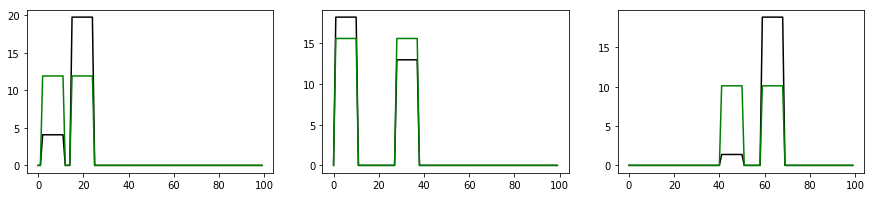

In [ ]:
noise_level = 0.0 # 0.3
nb_tried = 128*(20)
nb = 128

seed = np.random.randint(10000)
key = jax.random.PRNGKey(seed)

# in tr, and bx, first axis has actual triangle and box positions
inputs, targets, bxs = generate_sequences_boxes(nb_tried, noise_level, key, nb) 
print(inputs.shape)
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(inputs[0], 'k');
plt.plot(targets[0], 'g')
plt.subplot(132)
plt.plot(inputs[1], 'k');
plt.plot(targets[1], 'g')
plt.subplot(133)
plt.plot(inputs[2], 'k'); 
plt.plot(targets[2], 'g')

print(bxs[0:3])

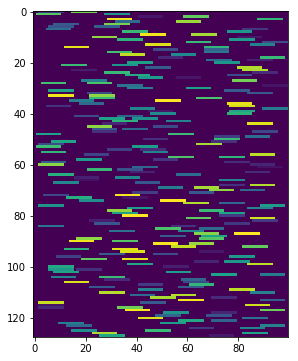

In [ ]:
plt.figure(figsize=(5,6))
plt.imshow(inputs)

In [ ]:
def soft_targets(targets):
  """Takes the boxes task, adds masks so as not to enforce discontinuities."""
  frac = 2.0/3.0 # How much of the top box should be enforced.

  masks = [] 
  for target in targets:
    bx_idxs = np.where(np.abs(np.diff(target)) > 0.0)[0]
    if bx_idxs.shape[0] == 3: # Last box stops on final index
      bx_idxs = np.concatenate((bx_idxs, [seq_length-2]))

    bx_idxs = np.reshape(bx_idxs, (2,2))

    mask = np.ones((seq_length,))
    for bxidx0, bxidx1 in bx_idxs:
      mask[bxidx0] = 0.0
      mask[bxidx1 + 1] = 0.0

      topidx0 = int(np.round(frac * bxidx0 + (1-frac) * bxidx1)) 
      topidx1 = int(np.round((1-frac) * bxidx0 + frac * bxidx1))
      mask[bxidx0:topidx0] = 0.0
      mask[(topidx1 + 1):(bxidx1 + 1)] = 0.0

    masks.append(mask)

  return targets, np.array(masks)

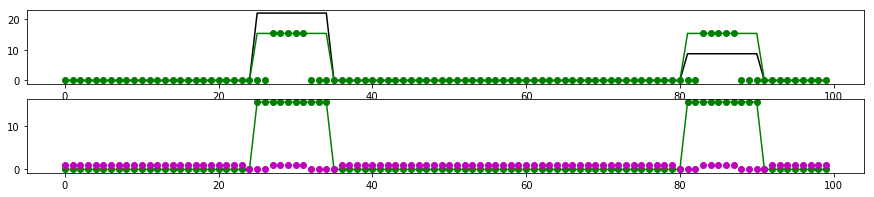

In [ ]:
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key, 2)
inputs, targets, bxs = generate_sequences_boxes(nb_tried, noise_level, skey, nb) 
stargets, masks = soft_targets(targets);

bidx = 16
plt.figure(figsize=(15,3))
plt.subplot(211)
plt.plot(inputs[bidx], 'k'); 
plt.plot(targets[bidx], 'g')
plt.plot(stargets[bidx] * masks[bidx], 'og')
plt.subplot(212)
plt.plot(targets[bidx], 'g')
plt.plot(stargets[bidx], 'og')
plt.plot(masks[bidx], 'om');


In [ ]:
def build_inputs_and_targets_batch(input_params, keys):
  batch_size, input_noise, list_len = input_params[0:3]

  input_bxtxu = onp.zeros([batch_size, list_len, NSymbols])
  target_bxtxo = onp.zeros([batch_size, list_len, 1])
  target_mask_bxtxo = onp.zeros([batch_size, list_len, 1])
  for bidx in tqdm(range(batch_size)):
    input_txu, review_idxs, review, rating_count, rating = \
        build_synthetic_review(input_params[2:], keys[bidx])

    key, subkey = random.split(keys[bidx], 2)
    noise = input_noise * random.normal(subkey, shape=input_txu.shape)
    input_bxtxu[bidx,:,:] = input_txu + noise
    target_bxtxo[bidx,:,:] = np.expand_dims(np.cumsum(rating_count,axis=0),1)
    target_mask_tx1 = onp.ones([list_len,1])
    target_mask_bxtxo[bidx,:,:] = target_mask_tx1

  return input_bxtxu, target_bxtxo, target_mask_bxtxo

In [ ]:
def build_inputs_and_targets_batch(input_params, batch_size, seed=0):
  nb_tried, nb, noise_level = input_params
  list_len = seq_length  # Should be properly threaded

  assert batch_size % nb == 0
  nbatches = batch_size // nb  # nb is a in ato, below.

  # Some odd interplay between jnp arrays and np arrays through here. 
  key = jax.random.PRNGKey(seed)
  subkeys = jax.random.split(key, nbatches)
  input_btu = np.zeros([batch_size, list_len, 1])
  soft_target_bto = np.zeros([batch_size, list_len, 1])
  mask_bto = np.zeros([batch_size, list_len, 1])
  for bidx in tqdm(range(nbatches)):
    input_at, target_at, _ = \
        generate_sequences_boxes(nb_tried, noise_level, subkeys[bidx], nb) 
    soft_target_at, mask_at = soft_targets(target_at);

    idxs = bidx * nb + np.arange(nb)
    input_btu[idxs, ...] = np.expand_dims(input_at, axis=2) / seq_height_max
    soft_target_bto[idxs, ...] = np.expand_dims(target_at, axis=2) / seq_height_max
    mask_bto[idxs, ...] = np.expand_dims(mask_at, axis=2)
  return input_btu, soft_target_bto, mask_bto

### Copy Task


From [https://github.com/MarkPKCollier/NeuralTuringMachine/blob/master/generate_data.py]

In [ ]:
# From

from scipy import spatial
import random

def set_random_seed(seed):
    np.random.seed(seed)

snap_boolean = np.vectorize(lambda x: 1.0 if x > 0.5 else 0.0)

class CopyTaskData:
    def generate_batches(self, num_batches, batch_size, bits_per_vector=8, curriculum_point=20, max_seq_len=20,
        curriculum='uniform', pad_to_max_seq_len=False):
        batches = []
        for i in tqdm(range(num_batches)):
            if curriculum == 'deterministic_uniform':
                seq_len = 1 + (i % max_seq_len)
            elif curriculum == 'uniform':
                seq_len = np.random.randint(low=1, high=max_seq_len+1)
            elif curriculum == 'none':
                seq_len = max_seq_len
            elif curriculum in ('naive', 'prediction_gain'):
                seq_len = curriculum_point
            elif curriculum == 'look_back':
                seq_len = curriculum_point if np.random.random_sample() < 0.9 else np.random.randint(low=1, high=curriculum_point+1)
            elif curriculum == 'look_back_and_forward':
                seq_len = curriculum_point if np.random.random_sample() < 0.8 else np.random.randint(low=1, high=max_seq_len+1)
            
            pad_to_len = max_seq_len if pad_to_max_seq_len else seq_len

            def generate_sequence():
                return np.asarray([snap_boolean(np.append(np.random.rand(bits_per_vector), 0)) for _ in range(seq_len)] \
                    + [np.zeros(bits_per_vector+1) for _ in range(pad_to_len - seq_len)])

            inputs = np.asarray([generate_sequence() for _ in range(batch_size)]).astype(np.float32)
            #eos = np.ones([batch_size, 1, bits_per_vector + 1])
            eos = np.concatenate((np.zeros((batch_size, 1, bits_per_vector)), 
                                 np.ones((batch_size, 1, 1))), axis=2)
            output_inputs = np.zeros_like(inputs)

            full_inputs = np.concatenate((inputs, eos, output_inputs), axis=1)

            batches.append((pad_to_len, full_inputs, inputs[:, :, :bits_per_vector]))
        return batches

    def error_per_seq(self, labels, outputs, num_seq):
        outputs[outputs >= 0.5] = 1.0
        outputs[outputs < 0.5] = 0.0
        bit_errors = np.sum(np.abs(labels - outputs))
        return bit_errors/num_seq

100%|██████████| 3/3 [00:00<00:00, 1855.89it/s]

(35, 9)


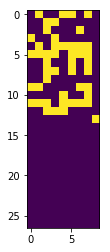

In [ ]:
copy_task_data = CopyTaskData()
batches = copy_task_data.generate_batches(3, 2)
print(batches[1][1][0,...].shape)
plt.imshow(batches[2][1][0,...])

In [ ]:
def copy_task_data_finish(batches, max_len=21):
  inputs = []
  targets = []
  masks = []
  for (input_len, full_inputs_btu, targets_bto) in batches:
    batch_size, ntime, ninputs  = batches[0][1].shape
    input = np.concatenate((full_inputs_btu[:,:input_len+1,:], 
                            np.zeros((batch_size, max_len-input_len-1, ninputs))), 
                            axis=1)
    target = np.concatenate((targets_bto, 
                             np.zeros((batch_size, max_len-input_len-1, ninputs-1))), 
                             axis=1)
    mask = np.concatenate((np.ones_like(targets_bto), 
                           np.zeros((batch_size, max_len-input_len-1, ninputs-1))), 
                           axis=1)
    inputs.append(input)
    targets.append(target)
    masks.append(mask)
    
  inputs = np.concatenate(inputs, axis=0)
  targets = np.concatenate(targets, axis=0)
  masks = np.concatenate(masks, axis=0)
  return inputs, targets, masks

In [ ]:
copy_task_data = CopyTaskData()
NumBatches = 1024
BatchSize = 128
TrainingSetSize = NumBatches * BatchSize
batches = copy_task_data.generate_batches(NumBatches, BatchSize)
Input_Btu, Target_Bto, Mask_Bto = copy_task_data_finish(batches)

100%|██████████| 1024/1024 [00:23<00:00, 44.39it/s]


In [ ]:
 def build_inputs_and_targets_subselect_copy(batch_size):
    ridxs = np.random.randint(0, TrainingSetSize, batch_size)
    input_btu = Input_Btu[ridxs,:,:]
    target_bto = Target_Bto[ridxs,:,:]
    mask_bto = Mask_Bto[ridxs,:,:]
    return input_btu, target_bto, mask_bto

In [ ]:
def plot_batch(ntime, input_btu, target_bto=None, output_bto=None,
               mask_bto=None, error_bto=None):
  bidx = 0
  plt.subplot(131)
  plt.imshow(input_btu[bidx,...])
  plt.subplot(132)
  plt.imshow(target_bto[bidx, ...])
  plt.subplot(133)
  plt.imshow(mask_bto[bidx, ...])

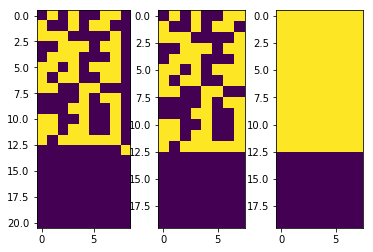

In [ ]:
input_btu, target_bto, mask_bto = build_inputs_and_targets_subselect_copy(128)
plot_batch(21, input_btu, target_bto, None, mask_bto)

In [ ]:
def my_fun(key):
  seq_length = 11
  info_length = 10
  batch_size = 4
  nbits = 2
  max_val = 2**nbits
  rand_bs = jax.random.randint(key, (batch_size, info_length, 1), 0, max_val) / max_val + 1/max_val
  inputs_part_1 = jnp.concatenate((rand_bs, jnp.zeros((batch_size, info_length, 1))), axis=2)
  inputs_part_2 = jnp.expand_dims(jnp.repeat(jnp.expand_dims(jnp.array([0.0, 1.0]), axis=1), batch_size, axis=1).T, axis=1)
  print(inputs_part_2.shape)
  inputs_part_3 = jnp.zeros((batch_size, seq_length - info_length - 1, 2))
  inputs = jnp.concatenate((inputs_part_1, inputs_part_2, inputs_part_3), axis=1)
  targets = inputs[:, :info_length, 0]
  #masks = jnp.concatenate((jnp.ones((batch_size, info_length, 1)), 
  #                         jnp.zeros((batch_size, 1, 1))), axis=1)
  masks = jnp.ones_like(targets)
  return inputs, targets, masks

In [ ]:
ntime_enc = 11
ntime_dec = 10
seed = np.random.randint(10000)

key = jax.random.PRNGKey(seed)
inputs_btu, targets_bto, masks_bto = my_fun(key)
print(inputs_btu.shape)
print(inputs_btu[0, ...], targets_bto[0, ...], masks_bto[0, ...])


(4, 1, 2)
(4, 11, 2)
[[1.   0.  ]
 [1.   0.  ]
 [0.5  0.  ]
 [1.   0.  ]
 [0.75 0.  ]
 [0.25 0.  ]
 [0.75 0.  ]
 [0.25 0.  ]
 [0.5  0.  ]
 [0.75 0.  ]
 [0.   1.  ]] [1.   1.   0.5  1.   0.75 0.25 0.75 0.25 0.5  0.75] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## RNN Code

### Utilities

In [ ]:
def ensure_dir(file_path):
  """Make sure the directory exists, create if it does not."""
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
    os.makedirs(directory)


def write_file(data_fname, data_dict):
  """Write a simple dictionary using h5py."""
  try:
    ensure_dir(data_fname)
    with h5py.File(data_fname, 'w') as hf:
      for k in data_dict:
        hf.create_dataset(k, data=data_dict[k])
        # add attributes
  except IOError:
    print("Cannot write % for writing." % data_fname)
    raise


def read_file(data_fname):
  """Read a simple dictionary of np arrays using h5py."""
  try:
    with h5py.File(data_fname, 'r') as hf:
      data_dict = {k: np.array(v) for k, v in hf.items()}
      return data_dict
  except IOError:
    print("Cannot open %s for reading." % data_fname)
    raise


def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = jax.random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [ ]:
def plot_batch(ntime, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               mask_bxtxo=None, error_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  ntoplot = 10
  plt.figure(figsize=(10,7))
  plt.subplot(311)
  plt.plot(input_bxtxu[0:ntoplot,:,0].T)
  plt.xlim([0, ntime-1])
  plt.ylabel('Inputs')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(output_bxtxo[0:ntoplot,:,0].T);
    plt.xlim([0, ntime-1]);
  if target_bxtxo is not None:
    plt.plot(target_bxtxo[0:ntoplot,:,0].T, '.');
    plt.xlim([0, ntime-1]);
    plt.ylabel("Target")
  if mask_bxtxo is not None:
    plt.plot(mask_bxtxo[0:ntoplot,:,0].T, '.');
    plt.xlim([0, ntime-1]);
    plt.ylabel("Mask")
  if error_bxtxo is not None:
    plt.subplot(313)
    plt.plot(error_bxtxo[0:ntoplot,:,0].T, '.');
    plt.xlim([0, ntime-1]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

### RNN functions for init, definition and running.

### Parameter initializations

In [ ]:
MAX_SEED_INT = 10000000


def affine_params(key, hps):
  """Params for y = w x + b
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyperparameters for an affine transformation
  Returns:
    a dictionary of parameters
  """
  key, skeys = keygen(key, 1)

  o = hps['output_dim']
  u = hps['input_dim']
  factor = 1.0
  if 'factor' in hps.keys():
    factor = hps['factor']
  if u > 0:
    factor = factor / jnp.sqrt(u)
  else:
    factor = 0.0

  return {'w' : jax.random.normal(next(skeys), (o, u)) * factor,
          'b' : jnp.zeros((o,))}


def gen_attn_params(key, hps):
  """Params for h' W x
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyperparameters for an affine transformation
  Returns:
    a dictionary of parameters
  """
  key, skeys = keygen(key, 1)

  e_dim = hps['enc_dim']
  d_dim = hps['dec_dim']
  factor = 1.0
  if 'factor' in hps.keys():
    factor = hps['factor']
  if e_dim > 0:
    factor = factor / jnp.sqrt(e_dim)
  else:
    factor = 0.0

  return {'W' : jax.random.normal(next(skeys), (d_dim, e_dim)) * factor}


def get_rnn_factors(hps):
  ifactor = 1.0
  if 'input_dim' in hps:
    if 'ifactor' in hps:
      ifactor = hps['ifactor']
    u = hps['input_dim']
    if u > 0:
      ifactor = ifactor / np.sqrt(u)
    else: 
      ifactor = 0.0

  hfactor = 1.0
  hscale = 0.0
  if 'hfactor' in hps:
    hfactor = hps['hfactor']
  if 'hscale' in hps:
    hscale = hps['hscale']
  n = hps['hidden_dim']
  hfactor = hfactor / np.sqrt(n)

  ofactor = 1.0
  if 'output_dim' in hps:
    if 'ofactor' in hps:
      ofactor = hps['ofactor']
    o = hps['output_dim']  
    if o > 0:
      ofactor = ofactor / np.sqrt(o)
    else: 
      ofactor = 0.0

  return (ifactor, hfactor, ofactor, hscale)


def vrnn_params(key, hps):
  """Generate Vanilla RNN parameters
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyper paramer dict to configure parameter creation for this VRNN
  Returns:
    a dictionary of parameters
  """
  ifactor, hfactor, _, hscale = get_rnn_factors(hps)
  u = hps['input_dim']
  n = hps['hidden_dim']

  key, skeys = keygen(key, 3)
  wJ = jax.random.normal(next(skeys), (n, n)) * hfactor
  wB = jax.random.normal(next(skeys), (n, u)) * ifactor
  wJB = jnp.concatenate((wJ, wB), axis=1)

  return {'h0' : jax.random.normal(next(skeys), (n,)) * hscale,
          'wJB' : wJB,
          'b' : np.zeros((n,))}


def vrnn_params_w_fb_inner(key, hps):
  """Generate Vanilla RNN parameters
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyper paramer dict to configure parameter creation for this VRNN
  Returns:
    a dictionary of parameters
  """
  ifactor, hfactor, ofactor, hscale = get_rnn_factors(hps)
  u = hps['input_dim']
  n = hps['hidden_dim']
  o = hps['output_dim']
  key, skeys = keygen(key, 4)
  wJ = jax.random.normal(next(skeys), (n, n)) * hfactor
  wB = jax.random.normal(next(skeys), (n, u)) * ifactor
  wF = jax.random.normal(next(skeys), (n, o)) * ofactor
  wJBF = jnp.concatenate((wJ, wB, wF), axis=1)

  return {'h0' : jax.random.normal(next(skeys), (n,)) * hscale,
          'wJB' : wJBF,
          'b' : np.zeros((n,))}


def gru_params(key, hps):
  """Generate GRU parameters
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyper paramer dict to configure parameter creation for this gru
  Returns:
    a dictionary of parameters
  """
  ifactor, hfactor, _, hscale = get_rnn_factors(hps)
  u = hps['input_dim']
  n = hps['hidden_dim']

  key, skeys = keygen(key, 5)
  wRUH = jax.random.normal(next(skeys), (n+n, n)) * hfactor
  wRUX = jax.random.normal(next(skeys), (n+n, u)) * ifactor
  wRUHX = np.concatenate([wRUH, wRUX], axis=1)

  wCH = jax.random.normal(next(skeys), (n, n)) * hfactor
  wCX = jax.random.normal(next(skeys), (n, u)) * ifactor
  wCHX = np.concatenate([wCH, wCX], axis=1)

  return {'h0' : jax.random.normal(next(skeys), (n,)) * hscale,
          'wRUHX' : wRUHX,
          'wCHX' : wCHX,
          'bRU' : np.zeros((n+n,)),
          'bC' : np.zeros((n,))}


def gru_params_w_fb_inner(key, hps):
  """Generate GRU parameters
  Arguments:
    key: random.PRNGKey for random bits
    hps: hyper paramer dict to configure parameter creation for this gru
  Returns:
    a dictionary of parameters
  """
  ifactor, hfactor, ofactor, hscale = get_rnn_factors(hps)
  u = hps['input_dim']
  n = hps['hidden_dim']
  o = hps['output_dim']

  key, skeys = keygen(key, 7)
  wRUH = jax.random.normal(next(skeys), (n + n, n)) * hfactor
  wRUX = jax.random.normal(next(skeys), (n + n, u)) * ifactor
  wRUZ = jax.random.normal(next(skeys), (n + n, o)) * ofactor
  wRUHXZ = np.concatenate([wRUH, wRUX, wRUZ], axis=1)

  wCH = jax.random.normal(next(skeys), (n, n)) * hfactor
  wCX = jax.random.normal(next(skeys), (n, u)) * ifactor
  wCZ = jax.random.normal(next(skeys), (n, o)) * ofactor
  wCHXZ = np.concatenate([wCH, wCX, wCZ], axis=1)

  return {'h0' : jax.random.normal(next(skeys), (n,)) * hscale,
          'wRUHX' : wRUHXZ,  # Using gru code
          'wCHX' : wCHXZ,    # Using gru code
          'bRU' : np.zeros((n+n,)),
          'bC' : np.zeros((n,))}


def vrnn_w_fb_params(key, hps):
  key, skey1, skey2 = jax.random.split(key, 3)
  return {'rnn': vrnn_params_w_fb_inner(skey1, hps['rnn']), 
          'affine': affine_params(skey2, hps['affine'])}


def gru_w_fb_params(key, hps):
  key, skey1, skey2 = jax.random.split(key, 3)
  return {'rnn': gru_params_w_fb_inner(skey1, hps['rnn']), 
          'affine': affine_params(skey2, hps['affine'])}


def vrnn_w_attn_params(key, hps):
  key, skey1, skey2, skey3 = jax.random.split(key, 4)
  print(hps)
  assert False, 'Needs h0_affine at least'
  return {'rnn': vrnn_params_w_fb_inner(skey1, hps['rnn']), 
          'affine': affine_params(skey2, hps['affine']),
          'attention' : ffn2_params(skey3, hps['attention'])}


def gru_w_attn_params(key, hps):
  key, skey0, skey1, skey2, skey3 = jax.random.split(key, 5)
  print(hps)
  return {'h0_affine': affine_params(skey0, hps['h0_affine']), 
          'rnn': gru_params_w_fb_inner(skey1, hps['rnn']), 
          'affine': affine_params(skey2, hps['affine']),
          'attention' : gen_attn_params(skey3, hps['attention'])}


def ffn2_params(key, hps):
  key1, key2 = jax.random.split(key, 2)
  return {'affine1' : affine_params(key1, hps['affine1']), 
          'affine2' : affine_params(key2, hps['affine2'])}


def seq2seq_params(key, hps):
  """Instantiate random seq2seq with attention parameters.
  Arguments:
    key: random.PRNGKey for random bits
    hps: a dict of seq2seq w attn hyperparameters
  Returns:
    a dictionary of seq2seq w attn parameters
  """
  key, skeys = keygen(key, 7)
  enc_fwd_h0_rnn_params = hps['enc_rnn_h0']['fwd_rnn']['params_fun']  # gru_params
  enc_bwd_h0_rnn_params = hps['enc_rnn_h0']['bwd_rnn']['params_fun']  # gru_params
  enc_fwd_attn_rnn_params = hps['enc_rnn_attn']['fwd_rnn']['params_fun']  # gru_params
  enc_bwd_attn_rnn_params = hps['enc_rnn_attn']['bwd_rnn']['params_fun']  # gru_params

  dec_rnn_params = hps['dec_rnn']['rnn']['params_fun']  # gru_w_attn_params
  return {'enc_rnn_h0': {'fwd_rnn': enc_fwd_h0_rnn_params(next(skeys), 
                                                          hps['enc_rnn_h0']['fwd_rnn']),
                         'bwd_rnn': enc_bwd_h0_rnn_params(next(skeys), 
                                                          hps['enc_rnn_h0']['bwd_rnn']), 
                         'affine': affine_params(next(skeys), hps['enc_rnn_h0']['affine'])},
                                                 
          'enc_rnn_attn': {'fwd_rnn': enc_fwd_attn_rnn_params(next(skeys), 
                                                              hps['enc_rnn_attn']['fwd_rnn']),
                           'bwd_rnn': enc_bwd_attn_rnn_params(next(skeys), 
                                                              hps['enc_rnn_attn']['bwd_rnn']),
                           'affine': affine_params(next(skeys), hps['enc_rnn_attn']['affine'])},
                                                   
          'dec_rnn' : dec_rnn_params(next(skeys), hps['dec_rnn'])}


def seq2seq_w_attn_params(key, hps):
  return seq2seq_params(key, hps)


### Core modules

In [ ]:
np.exp(1000) / np.exp(1000)

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_tpu_py3_sussillo.kernel.sussillo.1032262176200.14b334fb3717c109/mount/server/dm_notebook3_tpu.par:1: RuntimeWarning: invalid value encountered in double_scalars


nan

In [ ]:
safety_val = 0e-7
scale = 1e-6
vals = scale * np.array([0.0, 1.0, 2.0]) + safety_val

e_s = np.exp(vals)
ee_s = e_s / np.sum(e_s)

print(ee_s)

[0.333333   0.33333333 0.33333367]


In [ ]:
def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2.) + 1)

def affine(params, x):
  """Implement y = w x + b
  Arguments:
    params: a dictionary of params
    x: np array of input
  Returns:
    np array of output
  """
  return jnp.dot(params['w'], x) + params['b']


# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims)
# So map over first dimension to hand t_x_m.
# I.e. if affine yields n_y_1 = dot(n_W_m, m_x_1), then
# batch_affine yields t_y_n.
# And so the vectorization pattern goes for all batch_* functions.
batch_affine = jax.vmap(affine, in_axes=(None, 0))
batch_affine1 = jax.vmap(affine, in_axes=(None, 1))


def gen_attn(params, h, x):
  return jnp.dot(jnp.dot(h.T, params['W']), x)


# This is built for many xs to one h, as is done in attention in a seq2seq
# model for a single run.
batch_gen_attn = jax.vmap(gen_attn, in_axes=(None, None, 0))


def ffn2(params, x_u):
  h1_n = jnp.tanh(affine(params['affine1'], x_u))
  out_o = affine(params['affine2'], h1_n)
  return out_o


batch_ffn2 = jax.vmap(ffn2, in_axes=(None, 0))


def vrnn(params, h, x_n_noise):
  """Implement a Vanilla RNN."""
  x, noise = x_n_noise 
  hx = jnp.concatenate([h, x], axis=0)
  a = jnp.dot(params['wJB'], hx) + params['b'] + noise
  h = jnp.tanh(a)
  return h


def vrnn_w_fb(params, h, xzf_noise):
  h = vrnn(params['rnn'], h, xzf_noise)
  z = affine(params['affine'], h)
  return (h, z)


def gru(params, h, x_n_noise):
  """Implement the GRU equations.
  Arguments:
    params: dictionary of GRU parameters
    h: np array of  hidden state
    x_n_noise: np array of inputs and possible noise
  Returns:
    np array of hidden state after GRU update"""
  x, noise = x_n_noise 
  bfg = 0.0
  hx = jnp.concatenate([h, x], axis=0)
  ru = jnp.dot(params['wRUHX'], hx) + params['bRU']
  r, u = jnp.split(ru, 2, axis=0)
  u = u + bfg
  r = sigmoid(r)
  u = sigmoid(u)
  rhx = jnp.concatenate([r * h, x])
  c = jnp.tanh(jnp.dot(params['wCHX'], rhx) + params['bC'])
  return u * h + (1.0 - u) * c + noise


def gru_w_fb(params, h, xzf_noise):
  h = gru(params['rnn'], h, xzf_noise)
  z = affine(params['affine'], h)
  return (h, z)


def rnn_w_fb_tf(params, rnn_w_fb, h_z, x_f_m_noise_tf):
  h, z = h_z
  x, f, m, noise, tf = x_f_m_noise_tf
  zf = jnp.where(m, z * (1 - tf) + f * tf, z) # if target defined, can teacher force
  xz = jnp.concatenate((x, zf), axis=0)
  xz_noise = (xz, noise)
  return rnn_w_fb(params, h, xz_noise)


def vrnn_w_fb_tf(params, h_z, all_inputs):
  return rnn_w_fb_tf(params, vrnn_w_fb, h_z, all_inputs)


def gru_w_fb_tf(params, h_z, all_inputs):
  return rnn_w_fb_tf(params, gru_w_fb, h_z, all_inputs)


def my_softmax(x_s):
  max_x = jnp.max(x_s)
  y_s = x_s - max_x
  z_s = jnp.exp(y_s)
  return z_s / jnp.sum(z_s)

def rnn_w_attn_tf(params, rnn_w_fb, h_z_alpha_c, x_f_m_noise_tf):
  x_su, f_o, m_o, noise_n, tf = x_f_m_noise_tf # s is time dim of encoder

  nenctime = x_su.shape[0]
  h_n, z_o = h_z_alpha_c[0:2] # alpha and c_u are carried for scan, to return 
  zf_o = jnp.where(m_o, z_o * (1 - tf) + f_o * tf, z_o) # if target defined, can teacher force
  #h_sn = jnp.repeat(jnp.expand_dims(h_n, axis=0), nenctime, axis=0)
  #hx_snpu = jnp.concatenate((h_sn, x_su), axis=1) # tnpu -> T x N+U
  #e_sx1 = batch_ffn2(params['attention'], hx_snpu)
  #e_s = jnp.squeeze(e_sx1, axis=1)

  e_s = batch_gen_attn(params['attention'], h_n, x_su)
  alpha_s = my_softmax(e_s)
  alpha_s1 = jnp.expand_dims(alpha_s, axis=1)
  c_u = jnp.sum(alpha_s1 * x_su, axis=0)
  
  czf_upo = jnp.concatenate((c_u, zf_o), axis=0)
  czf_noise = (czf_upo, noise_n)
  s, z = rnn_w_fb(params, h_n, czf_noise)
  return s, z, alpha_s, c_u


def vrnn_w_attn_tf(params, h_z_alpha_c, all_inputs):
  return rnn_w_attn_tf(params, vrnn_w_fb, h_z_alpha_c, all_inputs)


def gru_w_attn_tf(params, h_z_alpha_c, all_inputs):
  return rnn_w_attn_tf(params, gru_w_fb, h_z_alpha_c, all_inputs)


def make_rnn_for_scan(rnn, params):
  """Scan requires f(h, x) -> h, h, in this application.
  Args: 
    rnn : f with sig (params, h, x) -> h
    params: params in f() sig.
  Returns: 
    f adapted for scan
  """
  def rnn_for_scan(h, x):
    h = rnn(params, h, x)
    return h, h
  return rnn_for_scan


def make_rnn_w_attn_for_scan(rnn, params, x_t):
  """Scan requires f(s, x) -> s, s, in this application.
  Args: 
    rnn : f with sig (params, s, x) -> s
    params: params in f() sig.
  Returns: 
    f adapted for scan
  """

  # 2nd parameter intentionally not used, rather x_t is. The 2nd parameter is 
  # required by scan, as scan runs over a list.
  def rnn_for_scan(s, f_m_noise_tf):
    f, m, noise, tf = f_m_noise_tf
    x_f_m_noise_tf = (x_t, f, m, noise, tf)
    s = rnn(params, s, x_f_m_noise_tf) 
    return s, s
  return rnn_for_scan


def run_rnn(key, hps, rnn_scan, x_t, h0):
  """Run an RNN module forward in time.
  Arguments:
    key: jax.random.PRNGKey for randomness
    hps: dict of hyperparmeters for the RNN
    rnn_scan: function for running RNN one step (h, x) -> (h, h)
      The params already embedded in the function.
    x_t: np array data for RNN input with leading dim being time
    h0: initial condition for running rnn
  Returns:
    np array of rnn applied to time data with leading dim being time"""
  key, subkey = jax.random.split(key, 2)
  noise_t = jax.random.normal(subkey, (hps['ntime'], hps['hidden_dim'])) 
  noise_t *= hps['noise_std']
  # noise_t = jnp.zeros((hps['ntime'], hps['hidden_dim']))
  _, h_t = jax.lax.scan(rnn_scan, h0, (x_t, noise_t))
  return h_t


def run_bidirectional_rnn(key, hps, params, fwd_rnn_scan, bwd_rnn_scan, 
                          x_t):
  """Run an RNN encoder backwards and forwards over some time series data.
  Arguments:
    params: a dictionary of bidrectional RNN encoder parameters
    fwd_rnn_scan: function for running forward rnn encoding
    bwd_rnn_scan: function for running backward rnn encoding
    x_t: np array data for RNN input with leading dim being time
  Returns:
    tuple of np array concatenated forward, backward encoding, and
      np array of concatenation of [forward_enc(T), backward_enc(1)]
  """
  key, skey1, skey2 = jax.random.split(key, 3)
  fwd_enc_tn = run_rnn(skey1, hps['fwd_rnn'], fwd_rnn_scan, 
                       x_t, params['fwd_rnn']['h0'])
  bwd_enc_tn = jnp.flipud(run_rnn(skey2, hps['bwd_rnn'], bwd_rnn_scan, 
                                  jnp.flipud(x_t), params['bwd_rnn']['h0']))
  full_enc_t2n = jnp.concatenate([fwd_enc_tn, bwd_enc_tn], axis=1)
  enc_ends_2n = jnp.concatenate([bwd_enc_tn[0], fwd_enc_tn[-1]], axis=0)

  full_enc_out_t2o = batch_affine1(params['affine'], full_enc_t2n.T)
  enc_ends_out_2o = affine(params['affine'], enc_ends_2n)
  return full_enc_out_t2o, enc_ends_out_2o 


def run_rnn_w_fb(key, hps, rnn_scan, x_t, f_t, m_t, h0, tf_value):
  """Run an RNN module forward in time.
  Arguments:
    key: jax.random.PRNGKey for randomness
    hps: dict of hyperparmeters for the RNN
    rnn_scan: function for running RNN one step (h, x) -> (h, h)
      The params already embedded in the function.
    x_t: np array data for RNN input with leading dim being time
    f_t: np array data for RNN target, used during training for teacher forcing
    m_t: mask for defined targets
    h0: initial condition for running rnn
    tf_value: teacher forcing percentage
  Returns:
    np array of rnn applied to time data with leading dim being time"""
  ntime = hps['rnn']['ntime']
  key, skey1, skey2 = jax.random.split(key, 3)
  noise_t = jax.random.normal(skey1, 
                              (ntime, hps['rnn']['hidden_dim'])) 
  noise_t *= hps['rnn']['noise_std']
  z0 = jnp.zeros_like(f_t[0])
  f_delayed_t = jnp.concatenate((jnp.expand_dims(z0, axis=0), f_t), axis=0)
  f_delayed_t = f_delayed_t[0:-1]
  m_delayed_t = jnp.concatenate((jnp.expand_dims(z0, axis=0), m_t), axis=0)
  m_delayed_t = m_delayed_t[0:-1]
  tf_t = jax.random.bernoulli(skey2, tf_value, (ntime,)).astype(np.float32)
  _, h_z = jax.lax.scan(rnn_scan, (h0, z0), 
                        (x_t, f_delayed_t, m_delayed_t, noise_t, tf_t))
  h_t, z_t = h_z
  return h_t, z_t


def run_rnn_w_attn(key, hps, rnn_scan, f_t, m_t, h0, tf_value):
  """Run an RNN module that uses attention forward in time.
  Arguments:
    rnn_scan: function for running RNN one step (s, x) -> (s, s)
      The params already embedded in the function.
    m_t: mask for defined targets
    h0: initial condition for running rnn
  Returns:
    np array of rnn applied to time data with leading dim being time"""

  ntime = hps['rnn']['ntime']
  key, skey1, skey2 = jax.random.split(key, 3)
  noise_t = jax.random.normal(skey1, 
                              (ntime, hps['rnn']['hidden_dim'])) 
  noise_t *= hps['rnn']['noise_std']

  z0 = jnp.zeros_like(f_t[0])
  f_delayed_t = jnp.concatenate((jnp.expand_dims(z0, axis=0), f_t), axis=0)
  f_delayed_t = f_delayed_t[0:-1]
  m_delayed_t = jnp.concatenate((jnp.expand_dims(z0, axis=0), m_t), axis=0)
  m_delayed_t = m_delayed_t[0:-1]
  tf_t = jax.random.bernoulli(skey2, tf_value, (ntime,)).astype(np.float32)

  # Scan requires a list to iterate over. Attention looks over the whole
  # sequence so we make something up here.
  print('Warning, ntime needs changed.')
  alpha0 = jnp.ones((ntime+1,)) / (ntime + 1)
  c0 = jnp.zeros((hps['rnn']['input_dim'],))
  _, h_z_alpha_c = jax.lax.scan(rnn_scan, (h0, z0, alpha0, c0), 
                                (f_delayed_t, m_delayed_t, noise_t, tf_t))
  return h_z_alpha_c

### Seq2Seq code

In [ ]:
def run_seq2seq_bidirectional_encoder(key, hps, params, x_tu):
  key, skey = jax.random.split(key, 2)
  # Encoder
  enc_fwd_rnn = hps['fwd_rnn']['rnn_fun']  # gru
  enc_bwd_rnn = hps['bwd_rnn']['rnn_fun']  # gru

  fwd_rnn_scan = make_rnn_for_scan(enc_fwd_rnn, params['fwd_rnn'])
  bwd_rnn_scan = make_rnn_for_scan(enc_bwd_rnn, params['bwd_rnn'])
  #import pdb; pdb.set_trace()
  full_enc_te, enc_end_2e = \
      run_bidirectional_rnn(skey, hps, params, 
                            fwd_rnn_scan, bwd_rnn_scan, x_tu)
  return full_enc_te, enc_end_2e


def run_seq2seq_rnn(key, hps, params, x_tu, f_to, m_to, tf_value):
  """Run an RNN encoder rnn over data, generate ic, run decoder from IC.
  Arguments:
    key: jax.random.PRNGKey for randomness
    hps: hyperparameter dict seq2seq model
    params: a dictionary of seq2seq RNN parameters
    x_tu: np array data for RNN input with leading dim being time
    f_to: targets, used for teacher forcing during training
    m_to: masks for targets, in case they are not defined everywhere
    tf_value: teacher forcing percentage
  Returns:
    A dictionary of all state from encoder and decoder RNNs, including
    initial condition for the decoder, and decoder output.
  """
  key, skey1, skey2 = jax.random.split(key, 3)

  # Encoder
  full_enc_te, enc_end_2e = \
      run_seq2seq_bidirectional_encoder(skey1, hps, params, x_tu)

  ntime = x_tu.shape[0]
  h0 = enc_end_2e

  # Decoder
  dec_rnn = hps['dec_rnn']['rnn']['rnn_fun']  # gru_w_attn_tf
  dec_rnn_scan = make_rnn_for_scan(dec_rnn, params['dec_rnn'])
  dec_td, out_to = run_rnn_w_fb(skey2, hps['dec_rnn'], dec_rnn_scan, 
                                jnp.zeros((ntime, 0)), f_to, m_to, h0, tf_value)

  return {'enc': full_enc_te, 'enc_ends': enc_end_2e, 
          'dec': dec_td, 'out': out_to}


def run_seq2seq_w_attn_rnn(key, hps, params, x_tu, f_to, m_to, tf_value):
  """Run an RNN encoder rnn over data, run decoder using attention.
  Arguments:
    key: jax.random.PRNGKey for randomness
    hps: hyperparameter dict seq2seq model
    params: a dictionary of seq2seq RNN parameters
    x_tu: np array data for RNN input with leading dim being time
    f_to: targets, used for teacher forcing during training
    tf_value: teacher forcing percentage
  Returns:
    A dictionary of all state from encoder and decoder RNNs, including
    initial condition for the decoder, and decoder output.
  """
  key, skey1, skey2 = jax.random.split(key, 3)

  # Encoder
  _, enc_end_2o = \
      run_seq2seq_bidirectional_encoder(skey1, hps['enc_rnn_h0'], 
                                        params['enc_rnn_h0'], x_tu)

  full_enc_to, _ = \
      run_seq2seq_bidirectional_encoder(skey1, hps['enc_rnn_attn'], 
                                        params['enc_rnn_attn'], x_tu)

  # Decoder
  dec_rnn = hps['dec_rnn']['rnn']['rnn_fun']  # gru_w_attn_tf
  dec_rnn_scan = make_rnn_w_attn_for_scan(dec_rnn, params['dec_rnn'], 
                                          full_enc_to)
  h0 = affine(params['dec_rnn']['h0_affine'], enc_end_2o)
  dec_td, out_to, alpha_t, c_tu = \
      run_rnn_w_attn(skey2, hps['dec_rnn'], dec_rnn_scan, f_to, m_to, h0, 
                     tf_value)

  return {'enc': full_enc_to, 'dec': dec_td, 'out': out_to,
          'dec_input' : c_tu, 'alpha' : alpha_t}


# Batching accomplished by vectorized mapping.
batch_seq2seq = jax.vmap(run_seq2seq_rnn, in_axes=(0, None, None, 0, 0, 0, None))
batch_seq2seq_w_attn = jax.vmap(run_seq2seq_w_attn_rnn, 
                                in_axes=(0, None, None, 0, 0, 0, None))

### Loss and gradients

In [ ]:
def get_tf_fun(hps):
  """Schedule for teacher forcing.
  Arguments:
    lfads_opt_hps : dictionary of optimization hyperparameters
  Returns:
    a function which yields teache forcing decay function
  """

  tf_decay_start = hps['tf_decay_start']
  tf_decay_stop = hps['tf_decay_stop']
  tf_min = hps['tf_min']
  tf_max = hps['tf_max']
  def tf_decay(batch_idx):
    progress_frac = ((batch_idx - tf_decay_start) /
                     (tf_decay_stop - tf_decay_start))
    tf_decay = np.where(batch_idx < tf_decay_start, tf_min,
                         (tf_max - tf_min) * progress_frac + tf_min)
    return np.where(batch_idx > tf_decay_stop, tf_max, tf_decay)
  return tf_decay


def seq2seq_loss(key, hps, params, x_btu, f_bto, m_bto, tf_value):
  """Compute the least squares loss of the output, plus L2 regularization."""
  batch_size = x_btu.shape[0]
  key_b = jax.random.split(key, batch_size)
  state = batch_run(key_b, hps, params, x_btu, f_bto, m_bto, tf_value)
  out_bto = state['out']

  l2_loss = hps['l2reg'] * optimizers.l2_norm(params)**2
  lms_loss = jnp.mean(m_bto*(out_bto - f_bto)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}


def seq2seq_loss_inf(key, hps, params, x_btu, f_bto, m_bto):
  """Compute the least squares loss of the output, plus L2 regularization."""
  batch_size = x_btu.shape[0]
  key_b = jax.random.split(key, batch_size)
  state = batch_run_inf(key_b, hps, params, x_btu)
  out_bto = state['out']

  l2_loss = hps['l2reg'] * optimizers.l2_norm(params)**2
  lms_loss = jnp.mean(m_bto*(out_bto - f_bto)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}


loss = seq2seq_loss
loss_jit = jax.jit(loss, static_argnums=(1,))
loss_inf = seq2seq_loss_inf


def update_w_gc(key, hps, i, opt_state, opt_update, get_params, x_btu, f_bto, m_bto,
                max_grad_norm, tf_value):
  """Update the parameters w/ gradient clipped, gradient descent updates."""
  params = get_params(opt_state)

  def training_loss(params, key, x_btu, f_bto, hps):
    return loss(key, hps, params, x_btu, f_bto, m_bto, tf_value)['total']
  
  key, subkey = jax.random.split(key)
  grads = jax.grad(training_loss)(params, subkey, x_btu, f_bto, hps)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)


update_w_gc_jit = jax.jit(update_w_gc, static_argnums=(1, 4, 5))

### Inference and plotting

In [ ]:
def run_trials(key, batch_run_fun, inputs_targets_h0s_fun):
  """Run a bunch of trials and save everything in a dictionary."""
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []

  skey1, skey2 = jax.random.split(key, 2)
  input_b, target_b, masks_b, h0s_b = inputs_targets_h0s_fun(skey1)
  run_key_b = jax.random.split(skey2, input_b.shape[0])
  if h0s_b is None:
    states = batch_run_fun(run_key_b, input_b)
  else:
    states = batch_run_fun(run_key_b, input_b, h0s_b)      
    h0s.append(h0s_b)
      
  trials = {'inputs': input_b, 'targets': target_b, 'masks': masks_b, 'h0s': h0s_b}
  return trials, states


def plot_examples_seq2seq(ntime, trials, states, nexamples=1, start_idx=0):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*4, 15))

  stop_idx = start_idx + nexamples
  #for pidx, bidx in enumerate(range(start_idx, stop_idx)):
  #  plt.subplot(4, nexamples, pidx+1)
  #  plt.plot(trials['inputs'][bidx,:], 'k')
  #  plt.xlim([0, ntime])
  #  plt.title('Example %d' % (bidx))
  #  if bidx == 0:
  #    plt.ylabel('Input')
      
  nplots = 6
  ntoplot = 10
  closeness = 0.25
  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 0*nexamples+pidx+1)
    enc_out_dim = states['enc'].shape[2]
    enc_n_toplot = ntoplot if enc_out_dim > ntoplot else enc_out_dim
    plt.plot(states['enc'][bidx, :, 0:ntoplot] +
             closeness * np.arange(ntoplot), 'b')
    plt.xlim([0, ntime])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Encoder Hidden Units')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 1*nexamples+pidx+1)
    plt.plot(states['dec'][bidx, :, 0:ntoplot] +
             closeness * np.arange(ntoplot), 'b')
    plt.xlim([0, ntime])
    if bidx == 0:
      plt.ylabel('Decoder Hidden Units')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 2*nexamples+pidx+1)   
    plt.plot(trials['inputs'][bidx,:], 'k', alpha=0.25)
    plt.plot(states['out'][bidx,:,:], 'r')
    plt.plot(trials['targets'][bidx,:,:] * trials['masks'][bidx,:,:], 'og')    
    #plt.plot(trials['masks'][bidx,:,:], 'om')    

    plt.xlim([0, ntime])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')


def plot_examples_seq2seq_w_attn(input_ntime, output_ntime, trials, states, nexamples=1, start_idx=0):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*4, 30))

  input_dim = trials['inputs'].shape[2]
  output_dim = states['out'].shape[2]
  stop_idx = start_idx + nexamples      
  nplots = 6
  ntoplot = 10
  closeness = 0.25
  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, nexamples+pidx+1)
    enc_out_dim = states['enc'].shape[2]
    enc_ntoplot = ntoplot if enc_out_dim > ntoplot else enc_out_dim
    plt.plot(states['enc'][bidx, :, 0:enc_ntoplot] +
             closeness * np.arange(enc_ntoplot), 'b')
    plt.xlim([0, input_ntime])
    plt.title('Example %d' % (bidx))
    if pidx == 0:
      plt.ylabel('Encoder Hidden Units')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 2*nexamples+pidx+1)
    dec_input_dim = states['dec_input'].shape[2]
    dec_input_ntoplot = ntoplot if dec_input_dim > ntoplot else dec_input_dim
    plt.plot(states['dec_input'][bidx, :, 0:dec_input_ntoplot] +
             closeness * np.arange(dec_input_ntoplot), 'b')
    plt.xlim([0, output_ntime])
    if pidx == 0:
      plt.ylabel('Decoder input')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 3*nexamples+pidx+1)
    plt.plot(states['dec'][bidx, :, 0:ntoplot] +
             closeness * np.arange(ntoplot), 'b')
    plt.xlim([0, output_ntime])
    if pidx == 0:
      plt.ylabel('Decoder Hidden Units')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 4*nexamples+pidx+1)
    plt.imshow((states['alpha'][bidx]).T)
    if pidx == 0:
      plt.ylabel('Attention (=1 along 0)')

  for pidx, bidx in enumerate(range(start_idx, stop_idx)):
    plt.subplot(nplots, nexamples, 5*nexamples+pidx+1)   
    plt.plot(trials['inputs'][bidx,:] + np.arange(input_dim), 'k', alpha=0.25)
    plt.plot(states['out'][bidx,:,:] + np.arange(output_dim), 'r')
    plt.plot(trials['targets'][bidx, :, :] * trials['masks'][bidx, :, :] + np.arange(output_dim), 'og')    
    plt.xlim([0, output_ntime])
    #plt.ylim([0, 1.0])
    plt.xlabel('Timesteps')
    if pidx == 0:
      plt.ylabel('Output')

## Fixed point finding code

In [ ]:
"""Find the fixed points of a nonlinear system via numerical optimization."""


def find_fixed_points(rnn_fun, candidates, hps, do_print=True):
  """Top-level routine to find fixed points, keeping only valid fixed points.
  This function will:
    Add noise to the fixed point candidates ('noise_var')
    Optimize to find the closest fixed points / slow points (many hps, 
      see optimize_fps)
    Exclude any fixed points whose fixed point loss is above threshold ('fp_tol')
    Exclude any non-unique fixed points according to a tolerance ('unique_tol')
    Exclude any far-away "outlier" fixed points ('outlier_tol')
    
  This top level function runs at the CPU level, while the actual JAX optimization 
  for finding fixed points is dispatched to device.
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    candidates: ndarray with shape npoints x ndims
    hps: dict of hyper parameters for fp optimization, including
      tolerances related to keeping fixed points
  
  Returns: 
    4-tuple of (kept fixed points sorted with slowest points first, 
      fixed point losses, indicies of kept fixed points, details of 
      optimization)"""

  npoints, dim = candidates.shape
  
  noise_var = hps['noise_var']
  if do_print and noise_var > 0.0:
    print("Adding noise to fixed point candidates.")
    candidates += np.random.randn(npoints, dim) * np.sqrt(noise_var)
    
  if do_print:
    print("Optimizing to find fixed points.")
  fps, opt_details = optimize_fps(rnn_fun, candidates, hps, do_print)

  if do_print and hps['fp_tol'] < np.inf:  
    print("Excluding fixed points with squared speed above tolerance {:0.5f}.".format(hps['fp_tol']))
  fps, fp_kidxs = fixed_points_with_tolerance(rnn_fun, fps, hps['fp_tol'],
                                              do_print)
  if len(fp_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details
  
  if do_print and hps['unique_tol'] > 0.0:  
    print("Excluding non-unique fixed points.")
  fps, unique_kidxs = keep_unique_fixed_points(fps, hps['unique_tol'],
                                               do_print)
  if len(unique_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details
  
  if do_print and hps['outlier_tol'] < np.inf:  
    print("Excluding outliers.")
  fps, outlier_kidxs = exclude_outliers(fps, hps['outlier_tol'],
                                        'euclidean', do_print) # TODO(sussillo) Make hp?
  if len(outlier_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details

  if do_print:
    print('Sorting fixed points slowest first.')    
  losses = np.array(get_fp_loss_fun(rnn_fun)(fps))# came back as jax.interpreters.xla.DeviceArray
  sort_idxs = np.argsort(losses) 
  fps = fps[sort_idxs]
  losses = losses[sort_idxs]
  try:
    keep_idxs = fp_kidxs[unique_kidxs[outlier_kidxs[sort_idxs]]]
  except:
    import pdb; pdb.set_trace()
  return fps, losses, keep_idxs, opt_details


def get_fp_loss_fun(rnn_fun):
  """Return the per-example mean-squared-error fixed point loss.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the loss for each example
  """
  batch_rnn_fun = jax.vmap(rnn_fun, in_axes=(0,))
  fp_fun = lambda h : jnp.mean((h - batch_rnn_fun(h))**2, axis=1)
  return jax.jit(fp_fun)


def get_total_fp_loss_fun(rnn_fun):
  """Return the MSE fixed point loss averaged across examples.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the average loss over all examples.
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  return jax.jit(lambda h : jnp.mean(fp_loss_fun(h)))


def optimize_fp_core(batch_idx_start, num_batches, update_fun, opt_state):
  """Gradient updates to fixed points candidates in order to find fixed points.
  Uses lax.fori_loop instead of a Python loop to reduce JAX overhead. This 
    loop will be jit'd and run on device.
  Arguments:
    batch_idx_start: Where are we in the total number of batches
    num_batches: how many batches to run
    update_fun: the function that changes params based on grad of loss
    opt_state: the jax optimizer state, containing params and opt state
  Returns:
    opt_state: the jax optimizer state, containing params and optimizer state"""

  def run_update(batch_idx, opt_state):
    opt_state = update_fun(batch_idx, opt_state)
    return opt_state

  lower = batch_idx_start
  upper = batch_idx_start + num_batches
  return jax.lax.fori_loop(lower, upper, run_update, opt_state)


#optimize_fp_core_jit = jax.jit(optimize_fp_core, static_argnums=(1, 2, 3))
optimize_fp_core_jit = optimize_fp_core

def optimize_fps(rnn_fun, fp_candidates, hps, do_print=True):
  """Find fixed points of the rnn via optimization.
  This loop is at the cpu non-JAX level.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1, for which the fixed point candidates are trained to be 
      fixed points
    fp_candidates: np array with shape (batch size, state dim) of hidden states 
      of RNN to start training for fixed points
    hps: fixed point hyperparameters
    do_print: Print useful information? 
  Returns:
    np array of numerically optimized fixed points"""

  total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun)

  def get_update_fun(opt_update, get_params):
    """Update the parameters using gradient descent.
    Arguments:
      opt_update: a function to update the optimizer state (from jax.optimizers)
      get_params: a function that extract parametrs from the optimizer state
    Returns:
      a 2-tuple (function which updates the parameters according to the 
        optimizer, a dictionary of details of the optimization)
    """
    def update(i, opt_state):
      params = get_params(opt_state)
      grads = jax.grad(total_fp_loss_fun)(params)    
      return opt_update(i, grads, opt_state)

    return update

  # Build some functions used in optimization.
  decay_fun = optimizers.exponential_decay(hps['step_size'],
                                           hps['decay_steps'],
                                           hps['decay_factor'])
  opt_init, opt_update, get_params = optimizers.adam(step_size=decay_fun,
                                                     b1=hps['adam_b1'],
                                                     b2=hps['adam_b2'],
                                                     eps=hps['adam_eps'])
  opt_state = opt_init(fp_candidates)
  update_fun = get_update_fun(opt_update, get_params)

  # Run the optimization, pausing every so often to collect data and
  # print status.
  batch_size = fp_candidates.shape[0]
  num_batches = hps['num_batches']
  print_every = hps['opt_print_every']
  num_opt_loops = int(num_batches / print_every)
  fps = get_params(opt_state)
  fp_losses = []
  do_stop = False
  for oidx in range(num_opt_loops):
    if do_stop:
      break
    batch_idx_start = oidx * print_every
    start_time = time.time()
    opt_state = optimize_fp_core_jit(batch_idx_start, print_every, update_fun,
                                     opt_state)
    batch_time = time.time() - start_time

    # Training loss
    fps = get_params(opt_state)
    batch_pidx = batch_idx_start + print_every
    total_fp_loss = total_fp_loss_fun(fps)
    fp_losses.append(total_fp_loss)
    
    # Saving, printing.
    if do_print:
      s = "    Batches {}-{} in {:0.2f} sec, Step size: {:0.5f}, Training loss {:0.5f}"
      print(s.format(batch_idx_start+1, batch_pidx, batch_time,
                     decay_fun(batch_pidx), total_fp_loss))

    if total_fp_loss < hps['fp_opt_stop_tol']:
      do_stop = True
      if do_print:
        print('Stopping as mean training loss {:0.5f} is below tolerance {:0.5f}.'.format(total_fp_loss, hps['fp_opt_stop_tol']))
    optimizer_details = {'fp_losses' : fp_losses}    
  return fps, optimizer_details


def fixed_points_with_tolerance(rnn_fun, fps, tol=np.inf, do_print=True):
  """Return fixed points with a fixed point loss under a given tolerance.
  
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    fps: ndarray with shape npoints x ndims
    tols: loss tolerance over which fixed points are excluded
    do_print: Print useful information? 
  Returns: 
    2-tuple of kept fixed points, along with indicies of kept fixed points
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  losses = fp_loss_fun(fps)
  lidxs = losses < tol
  keep_idxs = np.where(lidxs)[0]
  fps_w_tol = fps[lidxs]
  
  if do_print:
    print("    Kept %d/%d fixed points with tolerance under %f." %
          (fps_w_tol.shape[0], fps.shape[0], tol))
  
  return fps_w_tol, keep_idxs
  

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs


def exclude_outliers(data, outlier_dist=np.inf, metric='euclidean', do_print=True):
  """Exclude points whose closest neighbor is further than threshold.
  Args:
    data: ndarray, matrix holding datapoints (num_points x num_features).
    outlier_dist: float, distance to determine outliers.
    metric: str or function, distance metric passed to scipy.spatial.pdist.
        Defaults to "euclidean"
    do_print: Print useful information? 
  Returns:
    2-tuple of (filtered_data: ndarray, matrix holding subset of datapoints,
      keep_idx: ndarray, vector of bools holding indices of kept datapoints).
  """
  if np.isinf(outlier_dist):
    return data, np.arange(len(data))
  if data.shape[0] <= 1:
    return data, np.arange(len(data))

  # Compute pairwise distances between all fixed points.
  distances = squareform(pdist(data, metric=metric))

  # Find second smallest element in each column of the pairwise distance matrix.
  # This corresponds to the closest neighbor for each fixed point.
  closest_neighbor = np.partition(distances, 1, axis=0)[1]

  # Return data with outliers removed and indices of kept datapoints.
  keep_idx = np.where(closest_neighbor < outlier_dist)[0]
  data_to_keep = data[keep_idx]

  if do_print:
    print("    Kept %d/%d fixed points with within outlier tolerance %f." %
          (data_to_keep.shape[0], data.shape[0], outlier_dist))
  
  return data_to_keep, keep_idx                              


def compute_jacobians(rnn_fun, points):
  """Compute the jacobians of the rnn_fun at the points.
  This function uses JAX for the jacobian, and is computed on-device.
  Arguments:
    rnn_fun: RNN one step update function for a single hidden state vector
      h_t -> h_t+1
    points: np array npoints x dim, eval jacobian at this point.
  Returns: 
    npoints number of jacobians, np array with shape npoints x dim x dim
  """
  dFdh = jax.jacrev(rnn_fun)
  batch_dFdh = jax.jit(jax.vmap(dFdh, in_axes=(0,)))
  return batch_dFdh(points)


def compute_eigenvalue_decomposition(Ms, sort_by='magnitude',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.
  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.
  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sorted left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = np.linalg.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = np.linalg.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

# Training

### Hyperparameters

In [ ]:
do_simple_seq2seq = False

if do_simple_seq2seq:
  params_fun = seq2seq_params
  batch_run = batch_seq2seq
  plot_examples = plot_examples_seq2seq
else:
  params_fun = seq2seq_w_attn_params
  batch_run = batch_seq2seq_w_attn
  plot_examples = plot_examples_seq2seq_w_attn

In [ ]:
if do_simple_seq2seq:
  u = 1
  o = 1
  enc_n = 64
  enc_hfactor = 2.0
  enc_noise_std = 0.001

  dec_n = 128
  dec_hfactor = 2.0
  dec_noise_std = 0.001
  dec_ifactor = 1.0

  fwd_rnn_hps = {'rnn_fun': gru, 'params_fun': gru_params, 
                'input_dim': u, 'ntime': ntime_enc, 'hidden_dim': enc_n, 
                'hfactor': enc_hfactor, 'noise_std': enc_noise_std}
  bwd_rnn_hps = {'rnn_fun': gru, 'params_fun': gru_params,
                'input_dim': u, 'ntime': ntime_enc, 'hidden_dim': enc_n, 
                'hfactor': enc_hfactor, 'noise_std': enc_noise_std}
  enc_rnn_hps = {'fwd_rnn': fwd_rnn_hps, 'bwd_rnn': bwd_rnn_hps}


  dec_rnn_hps = {'rnn': {'rnn_fun': gru_w_fb_tf, 'params_fun': gru_w_fb_params,
                        'input_dim': 0, 'ntime': ntime_dec, 'hidden_dim': dec_n, 
                        'output_dim': o, 'hfactor': dec_hfactor, 'noise_std': dec_noise_std,
                        'ifactor': dec_ifactor}, 
                'affine': {'input_dim': dec_n, 'output_dim': o}}

  seq2seq_hps = {'enc_rnn': enc_rnn_hps, 'dec_rnn': dec_rnn_hps}


  hps = seq2seq_hps

  # Optimization hyperparameters
  num_batches = 15000         # Total number of batches to train on.

  batch_size = 128          # How many examples in each batch
  step_size = 0.025          # initial learning rate
  decay_factor = 0.9999     # decay the learning rate this much
  #step_size = 0.01          # initial learning rate
  #decay_factor = 0.9998     # decay the learning rate this much


  # Gradient clipping is HUGELY important for training RNNs
  max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
  l2reg = 2e-7           # amount of L2 regularization on the weights
  adam_b1 = 0.9             # Adam parameters
  adam_b2 = 0.999
  adam_eps = 1e-1
  print_every = 200          # Print training information every so often


  hps['l2reg'] = l2reg

  ohps = {'num_batches': num_batches, 'batch_size': batch_size, 
            'step_size': step_size, 'decay_factor': decay_factor, 
            'max_grad_norm': max_grad_norm, 'l2reg': l2reg, 
            'adam_b1': adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps, 
            'print_every': print_every}

else:
  #u = 1         # Number of inputs to the RNN
  #n = 256       # Number of units in the RNN
  #ic_dim = n
  #o = 1         # Number of outputs in the RNN

  # hfactor = 2.0
  # noise_std = 0.001

  #enc_rnn_hps = {'input_dim': u, 'ntime': seq_length, 'hidden_dim': n, 
  #               'hfactor': hfactor, 'noise_std': noise_std}
  #dec_rnn_hps = {'rnn': {'input_dim': 0, 'ntime': seq_length, 'hidden_dim': n, 
  #                       'output_dim': o, 'hfactor': hfactor, 'noise_std': noise_std}, 
  #               'affine': {'input_dim': n, 'output_dim': o}}
  #seq2seq_hps = {'enc_rnn': enc_rnn_hps, 'dec_rnn': dec_rnn_hps}



  #enc_rnn_hps = {'input_dim': u, 'ntime': seq_length, 'hidden_dim': n, 
  #               'hfactor': hfactor, 'noise_std': noise_std}
  u = 9 # 1
  o = 8 # 1
  enc_n = 128
  enc_output_dim = 128 # 4, We need 4 pieces of info (2 locations and 2 heights, no width changes)
  enc_hfactor = 2.0
  enc_noise_std = 0.001

  dec_n = 128
  dec_hfactor = 2.0
  dec_noise_std = 0.001
  dec_ifactor = 1.0

  input_seq_length = 21 # seq_length
  output_seq_length = 20 # seq_length

  enc_affine_hps = {'input_dim': 2 * enc_n, 'output_dim': enc_output_dim}
  fwd_rnn_hps = {'rnn_fun': gru, 'params_fun': gru_params, 
                'input_dim': u, 'ntime': input_seq_length, 'hidden_dim': enc_n, 
                'hfactor': enc_hfactor, 'noise_std': enc_noise_std}
  bwd_rnn_hps = {'rnn_fun': gru, 'params_fun': gru_params,
                'input_dim': u, 'ntime': input_seq_length, 'hidden_dim': enc_n, 
                'hfactor': enc_hfactor, 'noise_std': enc_noise_std}
  enc_rnn_h0_hps = {'fwd_rnn': fwd_rnn_hps, 'bwd_rnn': bwd_rnn_hps, 
                    'affine': enc_affine_hps}
  enc_rnn_attn_hps = {'fwd_rnn': fwd_rnn_hps, 'bwd_rnn': bwd_rnn_hps, 
                      'affine': enc_affine_hps}

  dec_rnn_hps = {'h0_affine': {'input_dim': enc_output_dim, 'output_dim': dec_n},
                'rnn': {'rnn_fun': gru_w_attn_tf, 'params_fun': gru_w_attn_params,
                        'input_dim': enc_output_dim, 'ntime': output_seq_length, 'hidden_dim': dec_n, 
                        'output_dim': o, 'hfactor': dec_hfactor, 'noise_std': dec_noise_std,
                        'ifactor': dec_ifactor}, 
                'affine': {'input_dim': dec_n, 'output_dim': o},
                'attention': {'enc_dim': enc_output_dim, 'dec_dim': dec_n}
                 }

  seq2seq_w_attn_hps = {'enc_rnn_h0': enc_rnn_h0_hps, 
                        'enc_rnn_attn': enc_rnn_attn_hps, 
                        'dec_rnn': dec_rnn_hps}


  # hps = seq2seq_hps
  hps = seq2seq_w_attn_hps


  # Optimization hyperparameters
  num_batches = 15000         # Total number of batches to train on.

  batch_size = 128          # How many examples in each batch
  step_size = 0.015          # initial learning rate
  decay_factor = 0.9999     # decay the learning rate this much
  #step_size = 0.01          # initial learning rate
  #decay_factor = 0.9998     # decay the learning rate this much


  # Gradient clipping is HUGELY important for training RNNs
  max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
  l2reg = 2e-7           # amount of L2 regularization on the weights
  adam_b1 = 0.9             # Adam parameters
  adam_b2 = 0.999
  adam_eps = 1e-1
  print_every = 200          # Print training information every so often


  hps['l2reg'] = l2reg

  ohps = {'num_batches': num_batches, 'batch_size': batch_size, 
            'step_size': step_size, 'decay_factor': decay_factor, 
            'max_grad_norm': max_grad_norm, 'l2reg': l2reg, 
            'adam_b1': adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps, 
            'print_every': print_every}

In [ ]:
hps

{'enc_rnn_h0': {'fwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.001},
  'bwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.001},
  'affine': {'input_dim': 256, 'output_dim': 128}},
 'enc_rnn_attn': {'fwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.001},
  'bwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.001},
  'affine': {'input_dim': 256, 'output_dim': 128}},
 'dec_rnn': {'h0_affine': {'input_dim': 128, 'output_dim': 128},
  'rn

In [ ]:
def build_inputs_and_targets_jit(input_params, key):
  nb, noise_level = input_params
  inputs_bt, targets_bt, bx = generate_sequences_boxes(nb_tried, noise_level, key, nb) 
  inputs_bt = inputs_bt / seq_height_max  # There are hard coded numbers in that awful code.
  targets_bt = targets_bt / seq_height_max 

  soft_targets_bt, masks_bt = soft_targets(targets_bt)
  inputs_btu = jnp.expand_dims(inputs_bt, axis=2)
  targets_btm = jnp.expand_dims(soft_targets_bt, axis=2)
  masks_btm = jnp.expand_dims(masks_bt, axis=2)
  return inputs_btu, targets_btm, masks_btm

One can optionally use the jit'd de-novo input/target maker, or try to generate a full training set first.

In [ ]:
if False:
  # This is to generate the full training set first, use 
  # build_inputs_and_targets_subselect(batch_size)
  noise_level = 0.3
  input_params = (nb_tried, nb, noise_level)
  TrainingSetSize = 128000
  Input_Btu, Target_Bto, Mask_Bto = \
      build_inputs_and_targets_batch(input_params, TrainingSetSize, seed)

  Input_Btu = jax.device_put(Input_Btu, jax.devices()[0])
  Target_Bto = jax.device_put(Target_Bto, jax.devices()[0])
  Mask_Bto = jax.device_put(Mask_Bto, jax.devices()[0])

  def build_inputs_and_targets_subselect(batch_size):
    ridxs = np.random.randint(0, TrainingSetSize, batch_size)
    input_btu = Input_Btu[ridxs,:,:]
    target_bto = Target_Bto[ridxs,:,:]
    mask_bto = Mask_Bto[ridxs,:,:]
    return input_btu, target_bto, mask_bto

  batch_size = 128
  input_btu, target_bto, mask_bto = build_inputs_and_targets_subselect(batch_size)

  plt.figure()
  plt.subplot(131)
  plt.imshow(input_btu[:,:,0])
  plt.subplot(132)
  plt.imshow(target_bto[:,:,0])
  plt.subplot(133)
  plt.imshow(mask_bto[:,:,0]);

In [ ]:
build_inputs_and_targets_subselect = build_inputs_and_targets_subselect_copy

Seed: 430013


TypeError: ignored

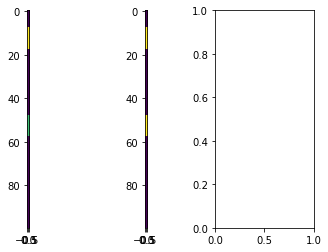

In [ ]:
seed = np.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot

noise_level = 0.0
input_params = (batch_size, noise_level)

# The number of examples to plot is given by the number of 
# random keys in this function.
key, skey = jax.random.split(key, 2)
skeys = jax.random.split(skey, ntoplot) # get ntoplot random keys

inputs, targets, masks = build_inputs_and_targets_jit(input_params, skey)

# Plot the input to the RNN and the target for the RNN.
plot_batch(seq_length, inputs[0:3], targets[0:3])

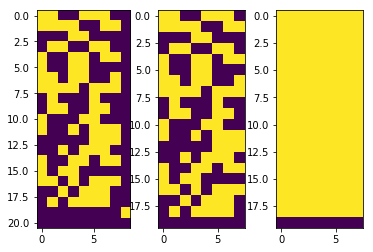

In [ ]:
if True:
  inputs, targets, masks = build_inputs_and_targets_subselect(batch_size)
  plot_batch(41, inputs[0:3], targets[0:3], None, masks[0:3], None)

In [ ]:
# Init some parameters for training.
params_seed = np.random.randint(100000)
params_key = jax.random.PRNGKey(params_seed)
key, subkey = jax.random.split(params_key, 2)

init_params = params_fun(subkey, hps)

{'h0_affine': {'input_dim': 128, 'output_dim': 128}, 'rnn': {'rnn_fun': <function gru_w_attn_tf at 0x7f353b302b70>, 'params_fun': <function gru_w_attn_params at 0x7f3548ab1268>, 'input_dim': 128, 'ntime': 20, 'hidden_dim': 128, 'output_dim': 8, 'hfactor': 2.0, 'noise_std': 0.001, 'ifactor': 1.0}, 'affine': {'input_dim': 128, 'output_dim': 8}, 'attention': {'enc_dim': 128, 'dec_dim': 128}}


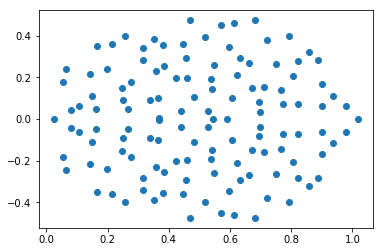

In [ ]:
x_zero = jnp.zeros((hps['dec_rnn']['rnn']['input_dim'] + hps['dec_rnn']['rnn']['output_dim'],))
noise_zero = jnp.zeros((hps['dec_rnn']['rnn']['hidden_dim'],))
rnn_fun = lambda h: gru_w_fb(init_params['dec_rnn'], h, (x_zero, noise_zero))[0]
dFdh = jax.jacobian(rnn_fun)

J = dFdh(jnp.zeros((dec_n,)))
evals, _ = np.linalg.eig(J)
plt.plot(np.real(evals), np.imag(evals), 'o');

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets_subselect(batch_size)
        #build_inputs_and_targets_jit(input_params, keys)
        
    h0s_b = None  # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b

zeros_bto = jnp.zeros((batch_size, output_seq_length, o))
masks_bto = np.ones((batch_size, output_seq_length, o))
rnn_run = lambda keys, inputs: batch_run(keys, hps, init_params, inputs, zeros_bto, masks_bto, 0.0)

inf_key, skey = jax.random.split(key, 2)
init_trials, init_states = run_trials(skey, rnn_run, inputs_targets_no_h0s)

Warning, ntime needs changed.


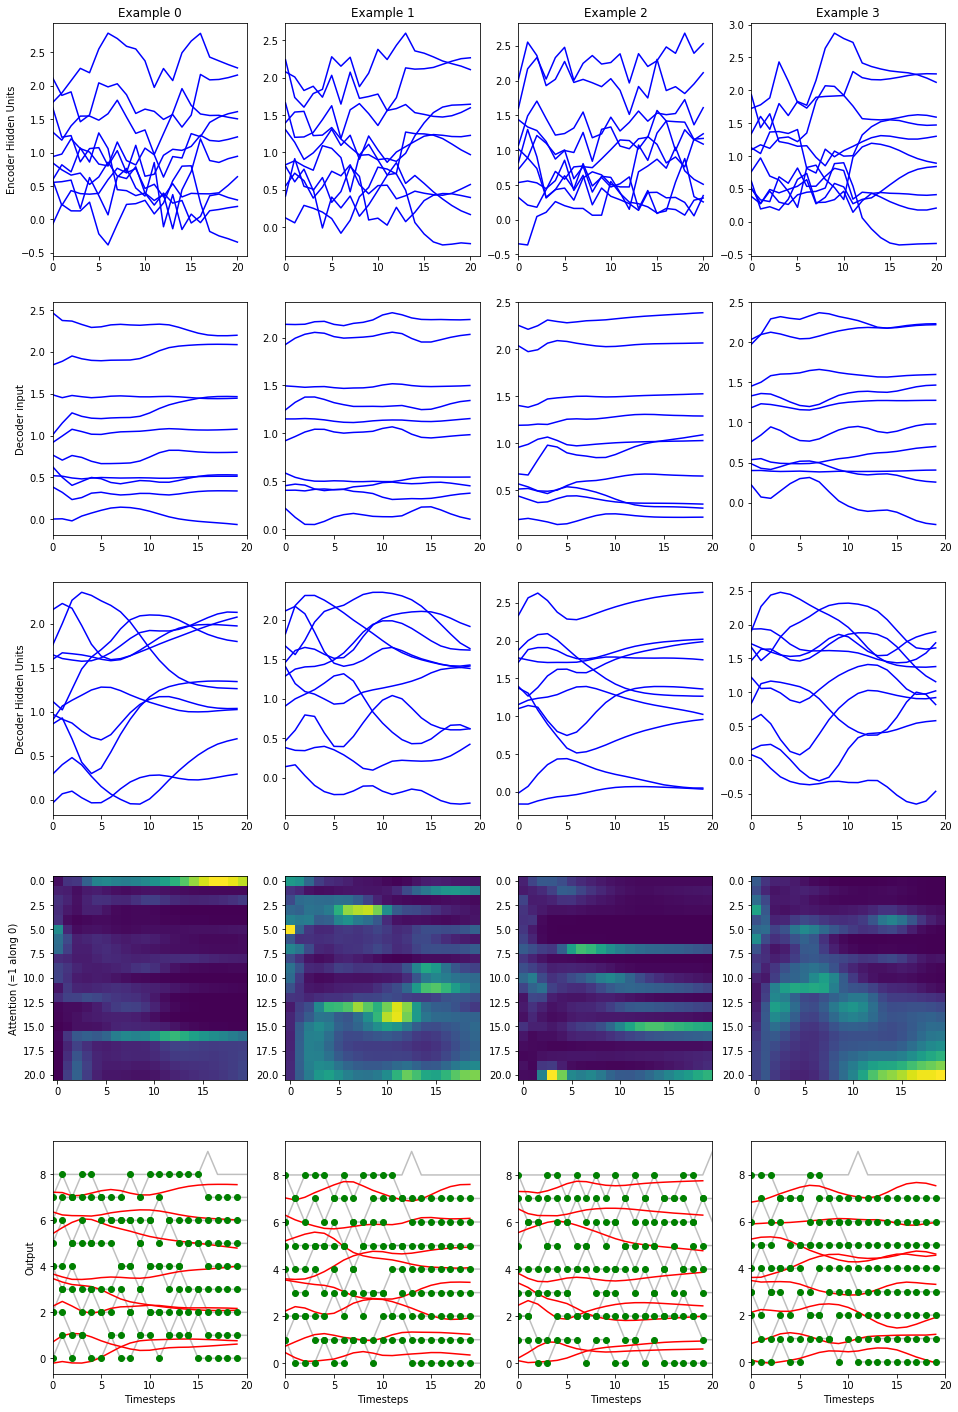

In [ ]:
# Visualize the hidden state, as an example.
start_idx = 0
plot_examples(input_seq_length, output_seq_length, init_trials, init_states, nexamples=4, start_idx=start_idx)

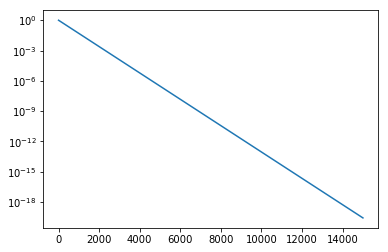

In [ ]:
tf_fun = optimizers.exponential_decay(1.0, decay_steps=1, 
                                      decay_rate=0.997)

plt.semilogy(np.array([tf_fun(x) for x in np.arange(0, num_batches)]))

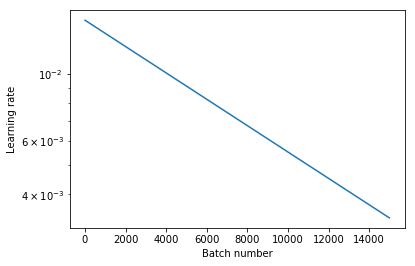

In [ ]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(ohps['step_size'], decay_steps=1, 
                                         decay_rate=ohps['decay_factor'])

batch_idxs = np.linspace(1, ohps['num_batches'])
plt.semilogy(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

### Train the RNN

In [ ]:
from jax.config import config
config.update("jax_debug_nans", True)

In [ ]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = \
    optimizers.adam(decay_fun, ohps['adam_b1'], ohps['adam_b2'], ohps['adam_eps'])
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
opt_seed = np.random.randint(1000000)
opt_key = jax.random.PRNGKey(opt_seed)
for batch in range(ohps['num_batches']):
  opt_key, skey1, skey2, skey3 = jax.random.split(opt_key, 4)
  inputs, targets, masks = build_inputs_and_targets_subselect(batch_size) #build_inputs_and_targets_jit(input_params, skey1)  #
  tf_value = tf_fun(batch)
  hps['dec_rnn']['rnn']['tf_value'] = tf_value
  opt_state = update_w_gc_jit(skey2, hps, batch, opt_state, opt_update, 
                              get_params, inputs, targets, masks, max_grad_norm, tf_value)
  if batch % print_every == 0:
    params = get_params(opt_state)
    all_train_losses.append(loss_jit(skey3, hps, params, inputs, targets, masks, tf_value))
    train_loss = all_train_losses[-1]['total']
    batch_time = time.time() - start_time
    step_size = decay_fun(batch)
    s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
    print(s.format(batch, batch_time, step_size, train_loss))
    start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Warning, ntime needs changed.
Warning, ntime needs changed.
Batch 0 in 7.46 sec, step size: 0.01500, training loss 0.2177
Batch 200 in 3.95 sec, step size: 0.01470, training loss 0.1228
Batch 400 in 4.19 sec, step size: 0.01441, training loss 0.1095
Batch 600 in 3.75 sec, step size: 0.01413, training loss 0.1079
Batch 800 in 4.00 sec, step size: 0.01385, training loss 0.0951
Batch 1000 in 4.09 sec, step size: 0.01357, training loss 0.0934
Batch 1200 in 3.89 sec, step size: 0.01330, training loss 0.0980
Batch 1400 in 3.74 sec, step size: 0.01304, training loss 0.0860
Batch 1600 in 3.89 sec, step size: 0.01278, training loss 0.0819
Batch 1800 in 3.98 sec, step size: 0.01253, training loss 0.0758
Batch 2000 in 3.99 sec, step size: 0.01228, training loss 0.0723
Batch 2200 in 3.94 sec, step size: 0.01204, training loss 0.0647
Batch 2400 in 3.95 sec, step size: 0.01180, training loss 0.0458
Batch 2600 in 3.76 sec, step size: 0.01157, training loss 0.0477
Batch 2800 in 3.89 sec, step size: 0.

### Show the loss through training.


In [ ]:
def find_nan(params, nesting=0, key_name=""):
  if isinstance(params, dict):
    for key in params:
      if isinstance(params[key], dict):
        print('\t'*nesting, key)
      find_nan(params[key], nesting+1, key)
  else:
    print('\t'*nesting, key_name, np.isnan(params).any())

#find_nan(params)


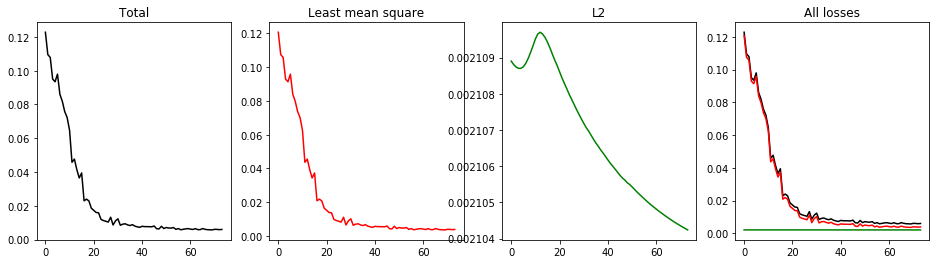

In [ ]:
xlims = [1, num_batches // print_every]
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.title('Total')

plt.subplot(142)
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.title('Least mean square')

plt.subplot(143)
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g');
plt.title('L2')

plt.subplot(144)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g')
plt.title('All losses');

### Save the network

In [ ]:
import datetime

save_dir = '/tmp/seq2seq/'       
rnn_type = 'seq2seq_w_gen_attn'
task_type = 'square_w_allowances'

# Make directories
data_dir = os.path.join(save_dir, 'data/')
output_dir = os.path.join(save_dir, 'output/')
figure_dir = os.path.join(save_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Load synthetic data
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                 fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
np.savez(network_path, params, hps, ohps)

Saving parameters:  /tmp/seq2seq/output/trained_params_seq2seq_w_gen_attn_square_w_allowances_2020-08-09_08:44:56.npz


In [ ]:
%download_file /tmp/seq2seq/output/trained_params_seq2seq_w_gen_attn_square_w_allowances_2020-08-09_08:44:56.npz

In [ ]:
# After training, you can load these up, after locating the save file.
if False:
  network_path = '/tmp/seq2seq/output/trained_params_seq2seq_w_gen_attn_square_w_allowances_2020-08-08_15:05:57.npz'
  loaded_params = np.load(network_path, allow_pickle=True)
  loaded_trained_params = loaded_params['arr_0'].item()
  loaded_hps = loaded_params['arr_1'].item()
  loaded_opt_hps = loaded_params['arr_2'].item()

In [ ]:
if False:
  hps = loaded_hps
  opt_hps = loaded_opt_hps
  params = loaded_trained_params

In [ ]:
inf_hps = copy.deepcopy(hps)

do_no_noise_eval = True
if do_no_noise_eval:
  inf_hps['enc_rnn_h0']['fwd_rnn']['noise_std'] = 0.0
  inf_hps['enc_rnn_h0']['bwd_rnn']['noise_std'] = 0.0
  inf_hps['enc_rnn_attn']['fwd_rnn']['noise_std'] = 0.0
  inf_hps['enc_rnn_attn']['bwd_rnn']['noise_std'] = 0.0
  inf_hps['dec_rnn']['rnn']['noise_std'] = 0.0

inf_hps

{'enc_rnn_h0': {'fwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.0},
  'bwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.0},
  'affine': {'input_dim': 256, 'output_dim': 128}},
 'enc_rnn_attn': {'fwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.0},
  'bwd_rnn': {'rnn_fun': <function __main__.gru>,
   'params_fun': <function __main__.gru_params>,
   'input_dim': 9,
   'ntime': 21,
   'hidden_dim': 128,
   'hfactor': 2.0,
   'noise_std': 0.0},
  'affine': {'input_dim': 256, 'output_dim': 128}},
 'dec_rnn': {'h0_affine': {'input_dim': 128, 'output_dim': 128},
  'rnn': {'rn

Warning, ntime needs changed.
Warning, ntime needs changed.
Loss on a new large batch: train: 0.0063751, eval: 0.0059392


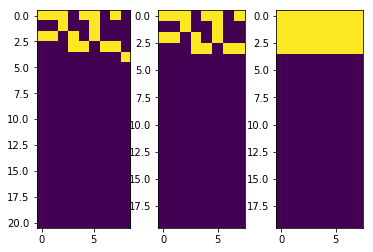

In [ ]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = get_params(opt_state)

inf_seed = np.random.randint(100000)
inf_key = jax.random.PRNGKey(inf_seed)
inf_key, skey1, skey2 = jax.random.split(inf_key, 3)
inputs, targets, masks = build_inputs_and_targets_subselect(batch_size) #build_inputs_and_targets_jit(input_params, skey1)

train_loss = loss(skey2, inf_hps, params, inputs, targets, masks, tf_value=1.0)['total']
train_loss_str = "{:.7f}".format(train_loss)

eval_loss = loss(skey2, inf_hps, params, inputs, targets, masks, tf_value=0.0)['total']
eval_loss_str = "{:.7f}".format(eval_loss)
print("Loss on a new large batch: train: %s, eval: %s" % (train_loss_str, eval_loss_str))


plot_batch(input_seq_length, inputs[0:1], targets[0:1], mask_bto=masks[0:1])

## Basic Visualizations

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets_subselect(batch_size)
        #build_inputs_and_targets_jit(input_params, keys)
        
    h0s_b = None  # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b

zeros_bto = jnp.zeros((batch_size, output_seq_length, o))
masks_bto = jnp.zeros((batch_size, output_seq_length, o))
rnn_run = lambda keys, inputs: batch_run(keys, inf_hps, params, inputs, 
                                         zeros_bto, masks_bto, 0.0)

inf_key, skey = jax.random.split(inf_key, 2)
trials, states = run_trials(skey, rnn_run, inputs_targets_no_h0s)

Warning, ntime needs changed.


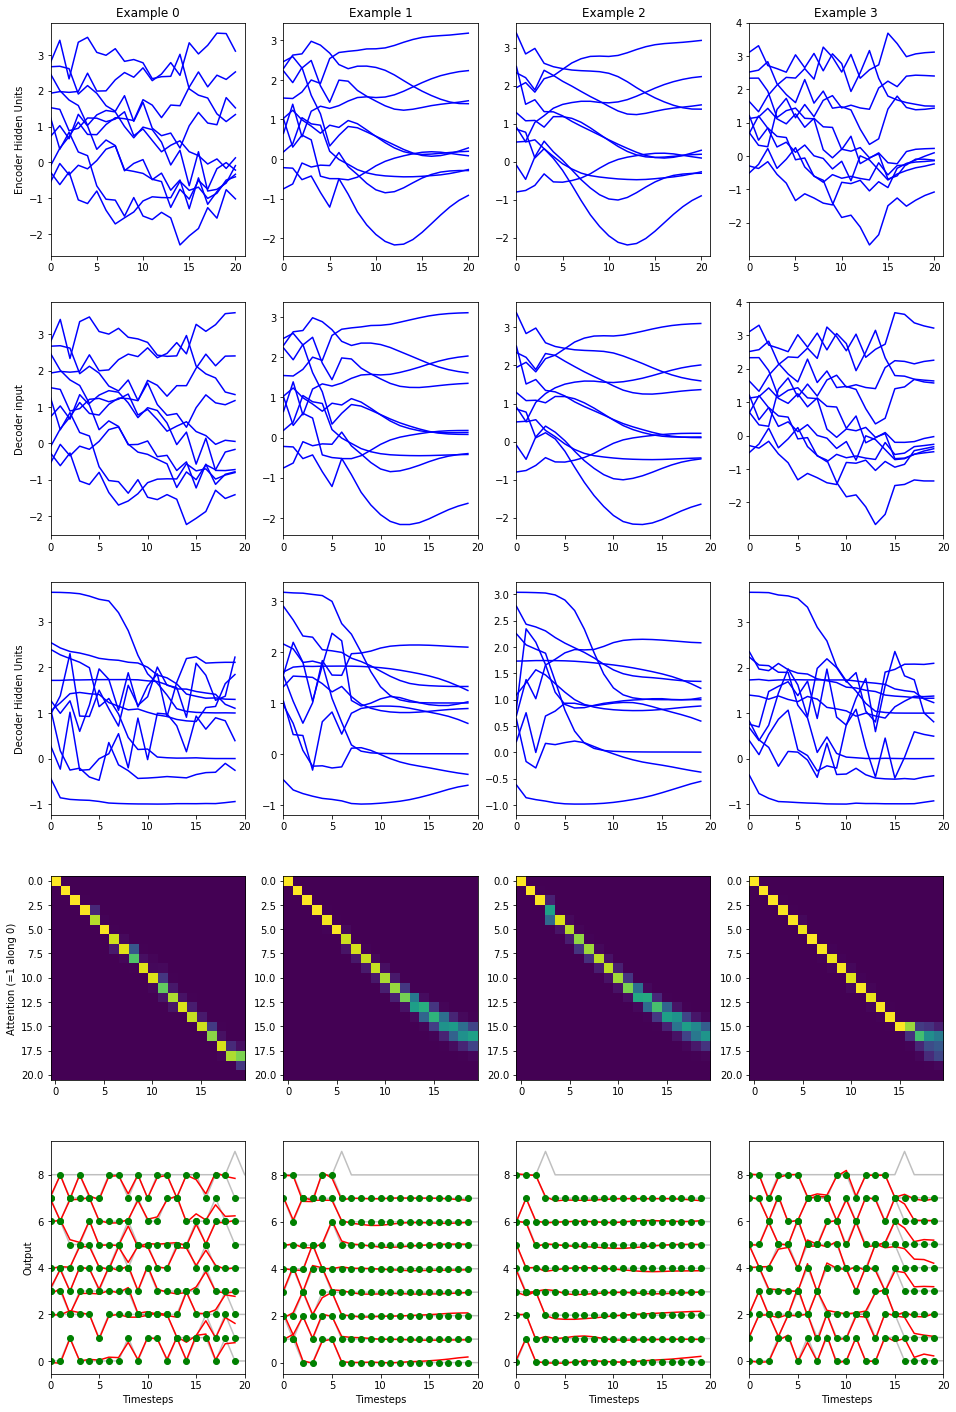

In [ ]:
# Visualize the hidden state, as an example.
start_idx = 0
plot_examples_seq2seq_w_attn(input_seq_length, output_seq_length, trials, states, nexamples=4, start_idx=start_idx)

In [ ]:
ntime = hps['dec_rnn']['rnn']['ntime']

(0, 19)

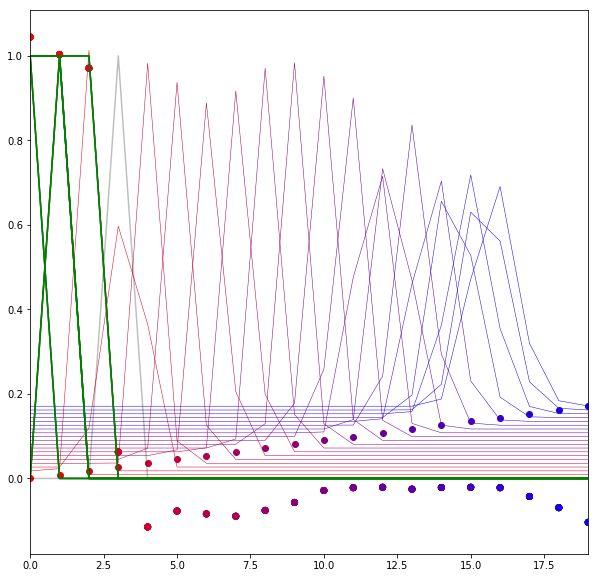

In [ ]:
bidx = start_idx + 2

ntime = hps['dec_rnn']['rnn']['ntime']
lift = 0.009

plt_idxs = np.arange(0, ntime)
eplt_idxs = np.arange(plt_idxs.shape[0])
plt.figure(figsize=(10,10))
colors = np.array([1 - np.arange(ntime)/ntime, np.zeros((ntime,)), np.arange(ntime)/ntime]).T
for pidx in plt_idxs:
  plt.plot(states['alpha'][bidx, pidx, :] + lift * pidx, lw=0.5, color=colors[pidx]);
  plt.scatter(pidx, 0*states['alpha'][bidx, pidx, pidx] + lift * pidx, c=colors[pidx]);

plt.xlim([0, ntime-1])

plt.plot(trials['inputs'][bidx], 'k', alpha=0.25)
plt.plot(trials['targets'][bidx], 'g')
for oidx in range(o):
  plt.scatter(np.arange(ntime), states['out'][bidx,:,o], c=colors);
plt.xlim([0, ntime-1])


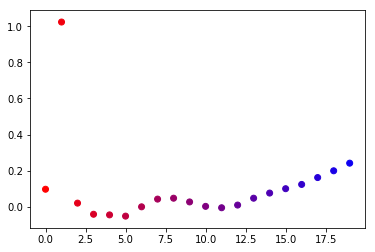

In [ ]:
plt.scatter(np.arange(ntime), states['out'][bidx, :, 0].T, c=colors);

#### Here are a few different ways of checking out the jacobian.

This peels back the layers of the onion, so to speak. 
1. Just the GRU with the FB
2. Then GRU with FB, and using the teacher forcing layer (should be the same as 1.)
3. Then the attention, so now linearizing around an entire input sequence.

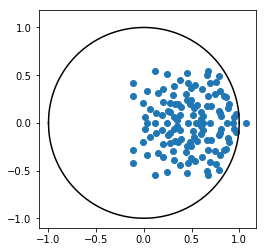

In [ ]:
# Build the function using the feedback loop function.
def rnn_fun_fb(h): 
  xzero = jnp.zeros((hps['dec_rnn']['rnn']['input_dim'],))
  noise_zero = jnp.zeros((hps['dec_rnn']['rnn']['hidden_dim'],))
  z = affine(params['dec_rnn']['affine'], h)
  xzero_z = jnp.concatenate((xzero, z), axis=0)
  return gru_w_fb(params['dec_rnn'], h, (xzero_z, noise_zero))[0]

dFdh = jax.jacobian(rnn_fun_fb)

J = dFdh(jnp.zeros((dec_n,)))
evals, _ = np.linalg.eig(J)
plt.plot(np.real(evals), np.imag(evals), 'o');
x = np.linspace(-1, 1, 500)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')
plt.axis('square');

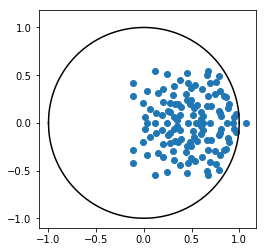

In [ ]:
# Build the function using the feedback loop with teacher forcing function.
def rnn_fun_tf(h):
  z = affine(params['dec_rnn']['affine'], h)
  xzero = jnp.zeros((hps['dec_rnn']['rnn']['input_dim'],))
  noise_zero = jnp.zeros((hps['dec_rnn']['rnn']['hidden_dim'],))
  x_f_m_noise_tf = (xzero, 0.0, 0.0, noise_zero, 0.0)
  return gru_w_fb_tf(params['dec_rnn'], (h, z), x_f_m_noise_tf)[0]


dFdh = jax.jacobian(rnn_fun_tf)
J = dFdh(jnp.zeros((dec_n,)))
#J = dFdh(np.random.randn(dec_n))
evals, _ = np.linalg.eig(J)

plt.plot(np.real(evals), np.imag(evals), 'o');
x = np.linspace(-1, 1, 500)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')
plt.axis('square');

In [ ]:
# Build the function using the feedback loop with teacher forcing function.
def get_rnn_fun_attn(example_idx):
  def rnn_fun_attn(h):
    z = affine(params['dec_rnn']['affine'], h)
    x_enc = states['enc'][example_idx,:,:]
    noise_zero = jnp.zeros((hps['dec_rnn']['rnn']['hidden_dim'],))
    x_f_m_noise_tf = (x_enc, 0.0, 0.0, noise_zero, 0.0)
    return gru_w_attn_tf(params['dec_rnn'], (h, z, (), ()), x_f_m_noise_tf)[0]

  return rnn_fun_attn


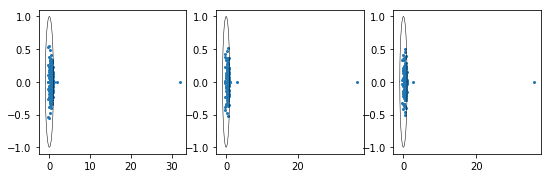

In [ ]:
rnn_funs = [get_rnn_fun_attn(eidx) for eidx in np.arange(3)]
batch_rnn_funs = [jax.vmap(rnn_fun) for rnn_fun in rnn_funs]

x = np.linspace(-1, 1, 500)
plt.figure(figsize=(9, 9))
for eidx, rnn_fun_attn in enumerate(rnn_funs):
  plt.subplot(3, 3, eidx+1)
  dFdh = jax.jacobian(rnn_fun_attn)
  J = dFdh(jnp.zeros((dec_n,)))
  evals, _ = np.linalg.eig(J)

  plt.plot(np.real(evals), np.imag(evals), 'o', ms=2);
  plt.plot(x, np.sqrt(1-x**2), 'k', lw=0.5)
  plt.plot(x, -np.sqrt(1-x**2), 'k', lw=0.5)

# Fixed point finding optimization

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.01          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.2      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = np.inf   # Any point whos closest fixed point is greater than tol is an outlier.

In [ ]:
from jax.config import config
config.update("jax_debug_nans", False)

In [ ]:
# These numbers are the most important for fixed point finding and are 
# tuned to this problem in particular! 

fps_by_example = {}

for eidx, rnn_fun in enumerate(rnn_funs):
  fp_tols = [0.0001, 0.00001] # Used for both fp_tol and opt_stop_tol

  fp_candidates = jax.device_get(states['dec'][eidx]) # was batch x time x dim
  fp_candidates = np.array(np.repeat(fp_candidates, 4, axis=0)) # requires fp_noise_var > 0.0

  all_fps = {}
  for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    
    fps, fp_losses, fp_idxs, fp_opt_details = \
        find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_funs[eidx](fps)
    else:
        F_of_fps = np.zeros([0, 256])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]

  fps_by_example[eidx] = all_fps

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-200 in 0.33 sec, Step size: 0.00980, Training loss 0.00539
    Batches 201-400 in 0.27 sec, Step size: 0.00961, Training loss 0.00219
    Batches 401-600 in 0.27 sec, Step size: 0.00942, Training loss 0.00128
    Batches 601-800 in 0.28 sec, Step size: 0.00923, Training loss 0.00088
    Batches 801-1000 in 0.28 sec, Step size: 0.00905, Training loss 0.00067
    Batches 1001-1200 in 0.28 sec, Step size: 0.00887, Training loss 0.00053
    Batches 1201-1400 in 0.29 sec, Step size: 0.00869, Training loss 0.00044
    Batches 1401-1600 in 0.27 sec, Step size: 0.00852, Training loss 0.00038
    Batches 1601-1800 in 0.29 sec, Step size: 0.00835, Training loss 0.00033
    Batches 1801-2000 in 0.27 sec, Step size: 0.00819, Training loss 0.00029
    Batches 2001-2200 in 0.27 sec, Step size: 0.00803, Training loss 0.00026
    Batches 2201-2400 in 0.26 sec, Step size: 0.00787, Training loss 0.00024
    Batches 24

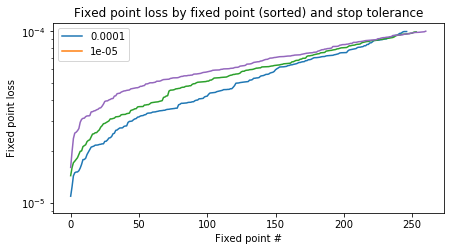

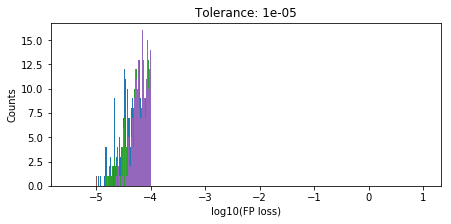

In [ ]:
f1 = plt.figure(figsize=(7,3.5))

for eidx, rnn_fun in enumerate(rnn_funs):
  for tol in fp_tols: 
    plt.semilogy(fps_by_example[eidx][tol]['losses']); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
  plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(7,3))
pidx = 1
nfp_tols = len(fp_tols)
for eidx, rnn_fun in enumerate(rnn_funs):
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  for tol_idx, tol in enumerate(fp_tols):
    plt.hist(np.log10(fp_loss_fun(fps_by_example[eidx][tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));
plt.ylabel('Counts');

In [ ]:
# Sort the best fixed points by projection onto the readoud.
out_W = params['dec_rnn']['affine']['w']
out_b = params['dec_rnn']['affine']['b']

eig_decomps_by_example = {}

for eidx, rnn_fun in enumerate(tqdm(rnn_funs)):
  best_tol = fp_tols[0]
  fps = fps_by_example[eidx][best_tol]['fps']
  if fps.shape[0] > 0:
    fp_readouts = np.squeeze(np.dot(out_W, fps.T) + np.expand_dims(out_b, axis=1))
    fp_ro_sidxs = np.argsort(fp_readouts)
    sorted_fp_readouts = fp_readouts[fp_ro_sidxs]
    sorted_fps = fps[fp_ro_sidxs]
    jacs = compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    eig_decomps_by_example[eidx] = eig_decomps

100%|██████████| 3/3 [00:20<00:00,  6.86s/it]


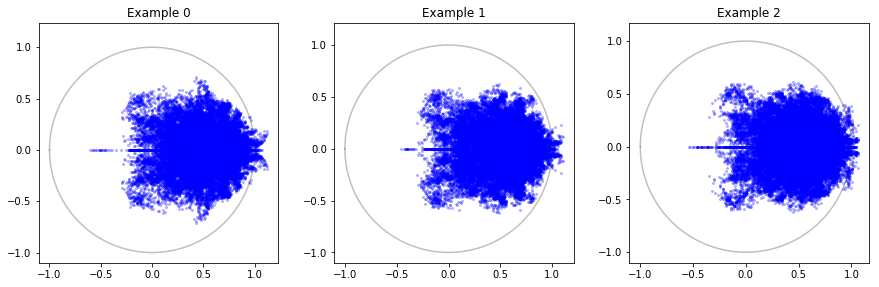

In [ ]:
x = np.linspace(-1, 1, 1000)
plt.figure(figsize=(15, 15))
for eidx, rnn_fun in enumerate(rnn_funs):
  eig_decomps = eig_decomps_by_example[eidx]
  plt.subplot(3, 3, eidx+1)

  plt.plot(x, np.sqrt(1-x**2), 'k', alpha=0.25)
  plt.plot(x, -np.sqrt(1-x**2), 'k', alpha=0.25)
  for fpidx, eig_decomp in enumerate(eig_decomps):
    evals = eig_decomp['evals']
    plt.plot(np.real(evals), np.imag(evals), 'bo', ms=2, alpha=0.25)

  plt.axis('square');
  plt.title(f'Example {eidx}')


# Analysis

In [ ]:
dec_hidden_dim = hps['dec_rnn']['rnn']['hidden_dim']
pca_data = np.reshape(states['dec'], (-1, dec_hidden_dim))
pca = PCA(n_components=3).fit(pca_data)

Q, R = np.linalg.qr(np.concatenate((out_W, pca.components_), axis=0).T)
P = Q[:,:3] # Not sure how to treat pca mean and output biases here.
P = P[:, [1,2, 0]]
P[:, 1] = -P[:, 1]
transform = lambda x_nb: np.dot(x_nb, P)

normed_readout = out_W / np.linalg.norm(out_W)
np.dot(pca.components_, normed_readout.T)

array([[0.05074516],
       [0.01568363],
       [0.0916041 ]], dtype=float32)

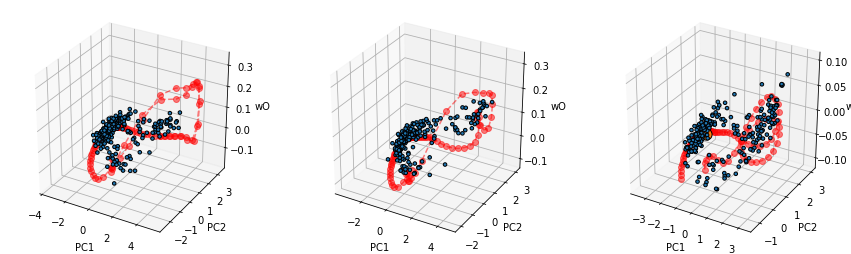

In [ ]:
fig = plt.figure(figsize=(15, 15));
for eidx, _ in enumerate(rnn_funs):
  all_fps = fps_by_example[eidx]
  ax = fig.add_subplot(3,3, eidx+1, projection='3d');

  max_fps_to_plot = 2000
  sizes = [50, 500]
  alpha = 0.5
  if True:
    for tol, size in zip(fp_tols[0:], sizes[0:]):

        hstars = np.reshape(all_fps[tol]['fps'], (-1, dec_hidden_dim))
        hstar_pca = transform(hstars)
        
        marker_style = dict(marker='.', s=size, edgecolor='none', alpha=1.0)
        #color = np.abs(eig_decomps_by_example[eidx]['evals'][0]) > 1.0
        emax = hstar_pca.shape[0]
        ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                  cmap='RdYlGn', **marker_style);

  alpha = 0.5
  tidx1 = 0
  tidx2 = hps['dec_rnn']['rnn']['ntime']

  if True:
    h_pca = transform(states['dec'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '--o', c=[1.0, 0.0, 0.0, alpha])  
  
  if True:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('wO')

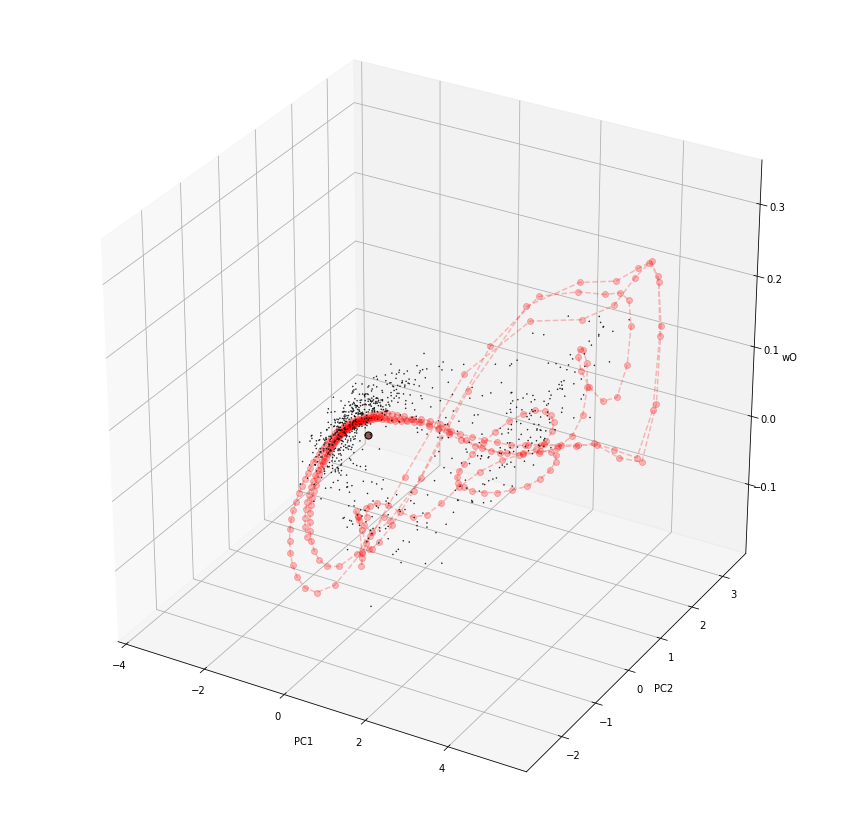

In [ ]:
fig = plt.figure(figsize=(15, 15));
ax = fig.add_subplot(1, 1, 1, projection='3d');

for eidx, _ in enumerate(rnn_funs):
  all_fps = fps_by_example[eidx]

  max_fps_to_plot = 2000
  sizes = [1, 200]
  alpha = 0.5
  if True:
    for tol, size in zip(fp_tols[0:], sizes[0:]):

        hstars = np.reshape(all_fps[tol]['fps'], (-1, dec_hidden_dim))
        hstar_pca = transform(hstars)
        
        marker_style = dict(marker='.', s=size, edgecolor='none', alpha=1.0)
        
        emax = hstar_pca.shape[0]
        ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                  cmap='RdYlGn', **marker_style);

  alpha = 0.25
  tidx1 = 0
  tidx2 = hps['dec_rnn']['rnn']['ntime']

  if True:
    h_pca = transform(states['dec'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '--o', c=[1.0, 0.0, 0.0, alpha])  
    
  if True:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('wO')

In [ ]:
  if False:
      hstar_pca = pca.transform(sorted_fps)
      
      marker_style = dict(marker='.', s=size, edgecolor='none', alpha=1.0)
      
      emax = hstar_pca.shape[0]
      ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                c=sorted_fps_stability[0:emax], **marker_style);